<a href="https://colab.research.google.com/github/jnlinao/VehicleImageClassification-DeepLearning/blob/main/Final_Code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
curDir = os.getcwd()
print(curDir) 

/Users/jnlinao/Library/Mobile Documents/com~apple~CloudDocs/UCI_21-22/Spring22/BANA 274/Assignments/HW3/Data_new


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import random
import matplotlib.pyplot as plt
import scipy.io
import math
import sklearn
import sklearn.datasets

#from opt_utils_v1a import load_params_and_grads, initialize_parameters, forward_propagation, backward_propagation
#from opt_utils_v1a import compute_cost, predict, predict_dec, plot_decision_boundary, load_dataset
#from testCases import *

import time
import scipy
from PIL import Image
from scipy import ndimage
#from dnn_app_utils_v3 import *
from sklearn.model_selection import train_test_split

%matplotlib inline
plt.rcParams['figure.figsize'] = (7.0, 4.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

#!pip install tensorflow
import glob
import h5py
#from dnn_utils_v2 import sigmoid, sigmoid_backward, relu, relu_backward
#from dnn_app_utils_v3 import *
#from reg_utils import sigmoid, relu, plot_decision_boundary, initialize_parameters, load_2D_dataset, predict_dec
#from reg_utils import compute_cost, predict, forward_propagation, backward_propagation, update_parameters
import sklearn
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout 
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.preprocessing import image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, BatchNormalization, Dropout, Conv2D, MaxPooling2D 
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.preprocessing import image

# Data Preprocessing

In [ ]:
imgs_non = glob.glob("drive/Shareddrives/Deep Learning/non-vehicles/*.png")
imgs_veh = glob.glob("drive/Shareddrives/Deep Learning/vehicles/*.png")

In [ ]:
random.seed(123)
imgs_non = random.sample(imgs_non,1000)
imgs_veh = random.sample(imgs_veh,1000)

In [ ]:
X = []
Y = []
for img in imgs_non:
    orig_im = Image.open(img)
    orig_array = np.asarray(orig_im)
    resized_img = Image.fromarray(orig_array).resize(size=(64, 64))
    resized_array = np.asarray(resized_img)
    X.append(resized_array)
    Y.append(0)

In [ ]:
for img in imgs_veh:
    orig_im = Image.open(img)
    orig_array = np.asarray(orig_im)
    resized_img = Image.fromarray(orig_array).resize(size=(64, 64))
    resized_array = np.asarray(resized_img)
    X.append(resized_array)
    Y.append(1)
X = np.asarray(X)
Y = np.asarray(Y)

In [ ]:
X_train, X_rem, Y_train, Y_rem = train_test_split(X,Y, train_size=0.6)
X_val, X_test, Y_val, Y_test = train_test_split(X_rem,Y_rem, test_size=0.5)

In [ ]:
train_set_x_flatten = X_train.reshape(X_train.shape[0],-1).T
test_set_x_flatten = X_test.reshape(X_test.shape[0],-1).T
val_set_x_flatten = X_val.reshape(X_val.shape[0],-1).T
train_set_y = Y_train.reshape(Y_train.shape[0], -1).T
test_set_y = Y_test.reshape(Y_test.shape[0], -1).T
val_set_y = Y_val.reshape(Y_val.shape[0], -1).T

# Summary Statistics

In [ ]:
X.shape

(2000, 64, 64, 3)

In [ ]:
pd.DataFrame(X.reshape((2000*64*64*3,))).describe() #convert into one-dimensional array and get summary statistics

,0
count,2.457600e+07
mean,8.053445e+01
std,5.997108e+01
min,0.000000e+00
25%,3.300000e+01
50%,7.000000e+01
75%,1.070000e+02
max,2.550000e+02


In [ ]:
Y.shape

(2000,)

In [ ]:
pd.DataFrame(Y).describe()

,0
count,2000.000000
mean,0.500000
std,0.500125
min,0.000000
25%,0.000000
50%,0.500000
75%,1.000000
max,1.000000


In [ ]:
# Normalization for X
X_nor = X/255

In [ ]:
X_nor.shape

(2000, 64, 64, 3)

In [ ]:
pd.DataFrame(X_nor.reshape((2000*64*64*3,))).describe() 

,0
count,2.457600e+07
mean,3.158214e-01
std,2.351807e-01
min,0.000000e+00
25%,1.294118e-01
50%,2.745098e-01
75%,4.196078e-01
max,1.000000e+00


In [ ]:
# Normalization
train_set_x = train_set_x_flatten/255
test_set_x = test_set_x_flatten/255
val_set_x = val_set_x_flatten/255

In [ ]:
print("train X shape: ", X_train.shape) # X_train: numpy array with shape: (num_samples_train, num_features)
print("train y shape: ", Y_train.shape) # y_train: numpy array with shape: (num_samples_train,) 
print("test X shape: ", X_test.shape)   # X_test: numpy array with shape: (num_samples_test, num_features)
print("test y shape: ", Y_test.shape)

train X shape:  (1200, 64, 64, 3)
train y shape:  (1200,)
test X shape:  (400, 64, 64, 3)
test y shape:  (400,)


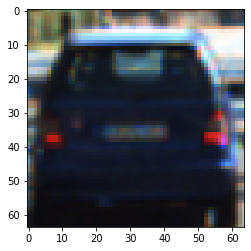

In [ ]:
i = 13
img = X_train[i, : , :]
plt.imshow(img)
plt.show()
#print(f"label: {labels[y_train[i]]}")

# Model Building

## Logistic Regression

In [ ]:
def initialize_with_zeros(dim):
    w = np.zeros((dim,1))
    b = 0
    
    assert(w.shape == (dim, 1))
    assert(isinstance(b, float) or isinstance(b, int))
    
    return w, b

# Helper function
def sigmoid(z):
    s = 1/(1+np.exp(-z))
    return s

# Helper function
def L(yhat, y):
    loss = -(y*np.log(yhat)+(1-y)*np.log(1-yhat))
    return loss

# Helper function
def C(yhat, y):
    m = y.shape[1]
    cost = 1/m*np.sum(L(yhat, y))
    return cost

# Forward and Backward propagation
# w -- weights, a numpy array of size (num_px * num_px * 3, 1)
# b -- bias, a scalar
# X -- data of size (num_px * num_px * 3, number of examples)
# Y -- true "label" vector (containing 0 if non-cat, 1 if cat) of size (1, number of examples)
# cost -- negative log-likelihood cost for logistic regression
# Dw -- gradient of the loss with respect to w, thus same shape as w
# Db -- gradient of the loss with respect to b, thus same shape as b
# the function returns the cost and gradients (Dw and Db)

def propagate(w, b, X, Y):

    m = X.shape[1]
    
    # FORWARD PROPAGATION (FROM X TO COST)
    A = sigmoid(np.dot(w.T,X)+b)                                    
    cost = C(A,Y)                                 
    
    
    # BACKWARD PROPAGATION (TO FIND GRAD)
    Dw = (1/m)*np.dot(X,(A-Y).T)
    Db = (1/m)*np.sum(A-Y)

    assert(Dw.shape == w.shape)
    assert(Db.dtype == float)
    cost = np.squeeze(cost)
    assert(cost.shape == ())
    
    grads = {"Dw": Dw,
             "Db": Db}
    
    return grads, cost

In [ ]:
# Optimization loop
def optimize(w, b, X, Y, num_iterations, learning_rate, print_cost = False):
    
    costs = []
    
    for i in range(num_iterations):
        grads, cost = propagate(w,b,X,Y)

        
        # Retrieve derivatives from grads
        Dw = grads["Dw"]
        Db = grads["Db"]
        
        # update rule 
        w = w - learning_rate*Dw
        b = b - learning_rate*Db
        
        # Record the costs
        if i % 100 == 0:
            costs.append(cost)
        
        # Print the cost every 100 training iterations
        if print_cost and i % 100 == 0:
            print ("Cost after iteration %i: %f" %(i, cost))
    
    params = {"w": w,
              "b": b}
    
    grads = {"Dw": Dw,
             "Db": Db}
    
    return params, grads, costs

In [ ]:
# Prediction
def predict(w, b, X):
    m = X.shape[1]
    Y_prediction = np.zeros((1,m))
    w = w.reshape(X.shape[0], 1)
    
    # Compute vector "A" predicting the probabilities of a cat being present in the picture
    A = sigmoid(np.dot(w.T,X) + b)
        
    for i in range(A.shape[1]):  
        # Convert probabilities A[0,i] to actual predictions p[0,i]
        Y_prediction[0,i] = 1 if A[0,i] > 0.5 else 0
    
    assert(Y_prediction.shape == (1, m))
    
    return Y_prediction

In [ ]:
def model(X_train, Y_train, X_test, Y_test, num_iterations = 2000, learning_rate = 0.5, print_cost = False):
    # initialize parameters with zeros 
    w, b = initialize_with_zeros(X_train.shape[0])

    # Gradient descent 
    parameters, grads, costs = optimize(w,b,X_train,Y_train,num_iterations,learning_rate,print_cost)
    
    # Retrieve parameters w and b from dictionary "parameters"
    w = parameters["w"]
    b = parameters["b"]
    
    # Predict test/train set examples 
    Y_prediction_test = predict(w,b,X_test)
    Y_prediction_train = predict(w,b,X_train)

    
    # Print train/test Errors
    print("train accuracy: {} %".format(100 - np.mean(np.abs(Y_prediction_train - Y_train)) * 100))
    print("test accuracy: {} %".format(100 - np.mean(np.abs(Y_prediction_test - Y_test)) * 100))

    
    d = {"costs": costs,
         "Y_prediction_test": Y_prediction_test, 
         "Y_prediction_train" : Y_prediction_train, 
         "w" : w, 
         "b" : b,
         "learning_rate" : learning_rate,
         "num_iterations": num_iterations}
    
    return d

In [ ]:
d = model(train_set_x, train_set_y, test_set_x, test_set_y, 
          num_iterations = 1000, learning_rate = 0.005, print_cost = True)


Cost after iteration 0: 0.693147
Cost after iteration 100: 0.361687
Cost after iteration 200: 0.305939
Cost after iteration 300: 0.275437
Cost after iteration 400: 0.254538
Cost after iteration 500: 0.238744
Cost after iteration 600: 0.226112
Cost after iteration 700: 0.215621
Cost after iteration 800: 0.206666
Cost after iteration 900: 0.198865
train accuracy: 94.66666666666667 %
test accuracy: 91.0 %


## Function to calculate the train model accuracy

In [ ]:
# Introduce function to train model accuracy

def get_train_accuracy(model, X_train, Y_train):
    test_loss, test_acc = model.evaluate(x=X_train, y=Y_train, verbose=0)
    print('accuracy: {acc:0.3f}'.format(acc=test_acc))

# Model Sequential

## 2-Question-D - Change Hidden Layers and Units

### #1

In [ ]:
# example 1:
model1 = Sequential([
                    Conv2D(filters=16, kernel_size=(3,3), strides=(1,1), padding='valid', activation = 'relu', input_shape=(64,64,3)), 
                    Flatten(),
                    #Dense(units=64, activation='relu', name='dense_1'),
                    Dense(1, activation = 'sigmoid')
])

model1.compile(
    optimizer = tf.keras.optimizers.Adamax(learning_rate=0.003, beta_1=0.9, beta_2=0.999, epsilon=1e-07), # the default values.
    loss = tf.keras.losses.BinaryCrossentropy(from_logits=True),          # use sigmoid activation, if in the final hidden layer, we do not specify an activation function or define a linear one.
    metrics = [tf.keras.metrics.BinaryAccuracy()]            # default is 0.5 (the threshold for predictions to be classed as positive).
)

In [ ]:
model1.fit(X_train, Y_train, epochs = 50, batch_size = 256, verbose = 2)

Epoch 1/50


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


5/5 - 3s - loss: 978.4801 - binary_accuracy: 0.5183 - 3s/epoch - 646ms/step
Epoch 2/50
5/5 - 1s - loss: 809.3361 - binary_accuracy: 0.4958 - 1s/epoch - 279ms/step
Epoch 3/50
5/5 - 1s - loss: 222.8432 - binary_accuracy: 0.5758 - 1s/epoch - 243ms/step
Epoch 4/50
5/5 - 1s - loss: 88.9180 - binary_accuracy: 0.6542 - 1s/epoch - 249ms/step
Epoch 5/50
5/5 - 1s - loss: 73.8865 - binary_accuracy: 0.6325 - 1s/epoch - 242ms/step
Epoch 6/50
5/5 - 1s - loss: 21.5263 - binary_accuracy: 0.8092 - 1s/epoch - 243ms/step
Epoch 7/50
5/5 - 1s - loss: 12.2187 - binary_accuracy: 0.8158 - 1s/epoch - 245ms/step
Epoch 8/50
5/5 - 1s - loss: 4.8077 - binary_accuracy: 0.8717 - 1s/epoch - 243ms/step
Epoch 9/50
5/5 - 1s - loss: 2.4115 - binary_accuracy: 0.9067 - 1s/epoch - 244ms/step
Epoch 10/50
5/5 - 1s - loss: 2.0846 - binary_accuracy: 0.9150 - 1s/epoch - 242ms/step
Epoch 11/50
5/5 - 1s - loss: 1.8220 - binary_accuracy: 0.9158 - 1s/epoch - 245ms/step
Epoch 12/50
5/5 - 1s - loss: 1.4103 - binary_accuracy: 0.9208 - 

In [ ]:
get_train_accuracy(model1, X_train, Y_train)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


accuracy: 0.998


In [ ]:
model1.evaluate(X_test,Y_test)

13/13 [==============================] - 0s 20ms/step - loss: 2.0204 - binary_accuracy: 0.9275


[2.0204269886016846, 0.9275000095367432]

### #2

In [ ]:
# example 2:
model2 = Sequential([
        Conv2D(filters=16, input_shape=(64, 64, 3), kernel_size=(2, 2), 
              activation='relu', name='conv_1'),
        Conv2D(filters=8, kernel_size=(3, 3), activation='relu', name='conv_2'),
        MaxPooling2D(pool_size=(4, 4), name='pool_1'),

        Flatten(),
        Dense(units=64, activation='relu', name='dense_1'),
        Dense(1, activation = 'sigmoid')
    ])


model2.compile(
    optimizer = tf.keras.optimizers.Adamax(learning_rate=0.003, beta_1=0.9, beta_2=0.999, epsilon=1e-07), # the default values.
    loss = tf.keras.losses.BinaryCrossentropy(from_logits=True),          # use sigmoid activation, if in the final hidden layer, we do not specify an activation function or define a linear one.
    metrics = [tf.keras.metrics.BinaryAccuracy()]            # default is 0.5 (the threshold for predictions to be classed as positive).
)

In [ ]:
model2.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_1 (Conv2D)             (None, 63, 63, 16)        208       
                                                                 
 conv_2 (Conv2D)             (None, 61, 61, 8)         1160      
                                                                 
 pool_1 (MaxPooling2D)       (None, 15, 15, 8)         0         
                                                                 
 flatten_2 (Flatten)         (None, 1800)              0         
                                                                 
 dense_1 (Dense)             (None, 64)                115264    
                                                                 
 dense_2 (Dense)             (None, 1)                 65        
                                                                 
Total params: 116,697
Trainable params: 116,697
Non-tr

In [ ]:
model2.fit(X_train, Y_train, epochs = 50, batch_size = 256, verbose = 2)

Epoch 1/50


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


5/5 - 5s - loss: 59.9916 - binary_accuracy: 0.5208 - 5s/epoch - 924ms/step
Epoch 2/50
5/5 - 4s - loss: 2.6178 - binary_accuracy: 0.5175 - 4s/epoch - 813ms/step
Epoch 3/50
5/5 - 4s - loss: 1.4815 - binary_accuracy: 0.3758 - 4s/epoch - 812ms/step
Epoch 4/50
5/5 - 4s - loss: 0.7804 - binary_accuracy: 0.5583 - 4s/epoch - 799ms/step
Epoch 5/50
5/5 - 4s - loss: 0.6779 - binary_accuracy: 0.6558 - 4s/epoch - 805ms/step
Epoch 6/50
5/5 - 4s - loss: 0.6435 - binary_accuracy: 0.6842 - 4s/epoch - 806ms/step
Epoch 7/50
5/5 - 4s - loss: 0.6201 - binary_accuracy: 0.7042 - 4s/epoch - 804ms/step
Epoch 8/50
5/5 - 4s - loss: 0.5948 - binary_accuracy: 0.7308 - 4s/epoch - 809ms/step
Epoch 9/50
5/5 - 4s - loss: 0.5568 - binary_accuracy: 0.7675 - 4s/epoch - 806ms/step
Epoch 10/50
5/5 - 4s - loss: 0.5106 - binary_accuracy: 0.7883 - 4s/epoch - 806ms/step
Epoch 11/50
5/5 - 4s - loss: 0.4430 - binary_accuracy: 0.8283 - 4s/epoch - 809ms/step
Epoch 12/50
5/5 - 4s - loss: 0.3780 - binary_accuracy: 0.8483 - 4s/epoch 

In [ ]:
get_train_accuracy(model2, X_train, Y_train)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


accuracy: 1.000


In [ ]:
model2.evaluate(X_test,Y_test)

13/13 [==============================] - 0s 34ms/step - loss: 0.3498 - binary_accuracy: 0.9400


[0.3497677743434906, 0.9399999976158142]

### #3

In [ ]:
# example 3:
model3 = Sequential([
                    Conv2D(filters=16, kernel_size=(3,3), strides=(1,1), padding='valid', activation = 'relu', input_shape=(64,64,3)), 
                    Flatten(),
                    Dense(units=64, activation='relu', name='dense_1'),
                    Dense(1, activation = 'sigmoid')
])

model3.compile(
    optimizer = tf.keras.optimizers.Adamax(learning_rate=0.003, beta_1=0.9, beta_2=0.999, epsilon=1e-07), # the default values.
    loss = tf.keras.losses.BinaryCrossentropy(from_logits=True),          # use sigmoid activation, if in the final hidden layer, we do not specify an activation function or define a linear one.
    metrics = [tf.keras.metrics.BinaryAccuracy()]            # default is 0.5 (the threshold for predictions to be classed as positive).
)

In [ ]:
model3.fit(X_train, Y_train, epochs = 50, batch_size = 256, verbose = 2)

Epoch 1/50


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


5/5 - 2s - loss: 982.6765 - binary_accuracy: 0.5125 - 2s/epoch - 472ms/step
Epoch 2/50
5/5 - 2s - loss: 363.5826 - binary_accuracy: 0.6442 - 2s/epoch - 373ms/step
Epoch 3/50
5/5 - 2s - loss: 99.7547 - binary_accuracy: 0.8150 - 2s/epoch - 367ms/step
Epoch 4/50
5/5 - 2s - loss: 74.2892 - binary_accuracy: 0.8667 - 2s/epoch - 365ms/step
Epoch 5/50
5/5 - 2s - loss: 39.9316 - binary_accuracy: 0.8467 - 2s/epoch - 363ms/step
Epoch 6/50
5/5 - 2s - loss: 15.6904 - binary_accuracy: 0.9350 - 2s/epoch - 366ms/step
Epoch 7/50
5/5 - 2s - loss: 10.0112 - binary_accuracy: 0.9500 - 2s/epoch - 375ms/step
Epoch 8/50
5/5 - 2s - loss: 6.3246 - binary_accuracy: 0.9525 - 2s/epoch - 369ms/step
Epoch 9/50
5/5 - 2s - loss: 4.1055 - binary_accuracy: 0.9658 - 2s/epoch - 363ms/step
Epoch 10/50
5/5 - 2s - loss: 3.2019 - binary_accuracy: 0.9700 - 2s/epoch - 372ms/step
Epoch 11/50
5/5 - 2s - loss: 2.2262 - binary_accuracy: 0.9800 - 2s/epoch - 368ms/step
Epoch 12/50
5/5 - 2s - loss: 1.9591 - binary_accuracy: 0.9792 - 2

In [ ]:
get_train_accuracy(model3, X_train, Y_train)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


accuracy: 1.000


In [ ]:
model3.evaluate(X_test,Y_test)

13/13 [==============================] - 0s 23ms/step - loss: 7.8050 - binary_accuracy: 0.9575


[7.804965972900391, 0.9574999809265137]

## 2-Question-e- Change Algorithms

In [ ]:
model_e1 = Sequential([
                    Conv2D(filters=16, kernel_size=(3,3), strides=(1,1), padding='valid', activation = 'relu', input_shape=(64,64,3)), 
                    Flatten(),
                    Dense(units=64, activation='relu', name='dense_1'),
                    Dense(1, activation = 'sigmoid')
])

### #1

In [ ]:
model_e1.compile(
    optimizer = tf.keras.optimizers.Adadelta(learning_rate=0.003,epsilon=1e-07), # the default values.
    loss = tf.keras.losses.BinaryCrossentropy(from_logits=True),          # use sigmoid activation, if in the final hidden layer, we do not specify an activation function or define a linear one.
    metrics = [tf.keras.metrics.BinaryAccuracy()]            # default is 0.5 (the threshold for predictions to be classed as positive).
)

In [ ]:
model_e1.fit(X_train, Y_train, epochs = 50, batch_size = 256, verbose = 2)

Epoch 1/50


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


5/5 - 3s - loss: 30.7099 - binary_accuracy: 0.5108 - 3s/epoch - 531ms/step
Epoch 2/50
5/5 - 2s - loss: 6.2283 - binary_accuracy: 0.5892 - 2s/epoch - 381ms/step
Epoch 3/50
5/5 - 2s - loss: 4.7883 - binary_accuracy: 0.6558 - 2s/epoch - 374ms/step
Epoch 4/50
5/5 - 2s - loss: 4.1837 - binary_accuracy: 0.6900 - 2s/epoch - 374ms/step
Epoch 5/50
5/5 - 2s - loss: 3.5159 - binary_accuracy: 0.7125 - 2s/epoch - 393ms/step
Epoch 6/50
5/5 - 2s - loss: 2.8279 - binary_accuracy: 0.7383 - 2s/epoch - 376ms/step
Epoch 7/50
5/5 - 2s - loss: 2.3536 - binary_accuracy: 0.7717 - 2s/epoch - 376ms/step
Epoch 8/50
5/5 - 2s - loss: 2.0560 - binary_accuracy: 0.7975 - 2s/epoch - 374ms/step
Epoch 9/50
5/5 - 2s - loss: 2.2193 - binary_accuracy: 0.7875 - 2s/epoch - 377ms/step
Epoch 10/50
5/5 - 2s - loss: 2.0555 - binary_accuracy: 0.7833 - 2s/epoch - 374ms/step
Epoch 11/50
5/5 - 2s - loss: 1.7399 - binary_accuracy: 0.8275 - 2s/epoch - 377ms/step
Epoch 12/50
5/5 - 2s - loss: 1.5077 - binary_accuracy: 0.8492 - 2s/epoch 

In [ ]:
get_train_accuracy(model_e1, X_train, Y_train)

accuracy: 0.964


In [ ]:
model_e1.evaluate(X_test,Y_test)

13/13 [==============================] - 0s 34ms/step - loss: 1.1775 - binary_accuracy: 0.8625


[1.1774715185165405, 0.862500011920929]

### #2

In [ ]:
#this part is the same as model_e1(using the best combinition of hidden layers and units)
model_e2 = Sequential([
                    Conv2D(filters=16, kernel_size=(3,3), strides=(1,1), padding='valid', activation = 'relu', input_shape=(64,64,3)), 
                    Flatten(),
                    Dense(units=64, activation='relu', name='dense_1'),
                    Dense(1, activation = 'sigmoid')
])

In [ ]:
model_e2.compile(
    optimizer = tf.keras.optimizers.Adagrad(learning_rate=0.003), # the default values.
    loss = tf.keras.losses.BinaryCrossentropy(from_logits=True),          # use sigmoid activation, if in the final hidden layer, we do not specify an activation function or define a linear one.
    metrics = [tf.keras.metrics.BinaryAccuracy()]            # default is 0.5 (the threshold for predictions to be classed as positive).
)

In [ ]:
model_e2.fit(X_train, Y_train, epochs = 50, batch_size = 256, verbose = 2)

Epoch 1/50


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


5/5 - 2s - loss: 1873.9045 - binary_accuracy: 0.4992 - 2s/epoch - 497ms/step
Epoch 2/50
5/5 - 2s - loss: 457.4643 - binary_accuracy: 0.5433 - 2s/epoch - 373ms/step
Epoch 3/50
5/5 - 2s - loss: 153.9944 - binary_accuracy: 0.5775 - 2s/epoch - 432ms/step
Epoch 4/50
5/5 - 4s - loss: 36.5728 - binary_accuracy: 0.8183 - 4s/epoch - 759ms/step
Epoch 5/50
5/5 - 3s - loss: 15.8677 - binary_accuracy: 0.8833 - 3s/epoch - 614ms/step
Epoch 6/50
5/5 - 2s - loss: 11.9004 - binary_accuracy: 0.8992 - 2s/epoch - 460ms/step
Epoch 7/50
5/5 - 2s - loss: 9.3064 - binary_accuracy: 0.9200 - 2s/epoch - 370ms/step
Epoch 8/50
5/5 - 2s - loss: 8.8547 - binary_accuracy: 0.9050 - 2s/epoch - 363ms/step
Epoch 9/50
5/5 - 2s - loss: 6.0349 - binary_accuracy: 0.9300 - 2s/epoch - 368ms/step
Epoch 10/50
5/5 - 2s - loss: 4.6141 - binary_accuracy: 0.9383 - 2s/epoch - 370ms/step
Epoch 11/50
5/5 - 2s - loss: 4.1904 - binary_accuracy: 0.9433 - 2s/epoch - 368ms/step
Epoch 12/50
5/5 - 2s - loss: 54.2959 - binary_accuracy: 0.7267 -

In [ ]:
get_train_accuracy(model_e2, X_train, Y_train)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


accuracy: 0.998


In [ ]:
model_e2.evaluate(X_test,Y_test)

13/13 [==============================] - 0s 25ms/step - loss: 3.6831 - binary_accuracy: 0.9450


[3.6830708980560303, 0.9449999928474426]

### #3

In [ ]:
#this part is the same as model_e1(using the best combinition of hidden layers and units)
model_e3 = Sequential([
                    Conv2D(filters=16, kernel_size=(3,3), strides=(1,1), padding='valid', activation = 'relu', input_shape=(64,64,3)), 
                    Flatten(),
                    Dense(units=64, activation='relu', name='dense_1'),
                    Dense(1, activation = 'sigmoid')
])

In [ ]:
model_e3.compile(
    optimizer = tf.keras.optimizers.Adamax(learning_rate=0.003,epsilon=1e-07), # the default values.
    loss = tf.keras.losses.BinaryCrossentropy(from_logits=True),          # use sigmoid activation, if in the final hidden layer, we do not specify an activation function or define a linear one.
    metrics = [tf.keras.metrics.BinaryAccuracy()]            # default is 0.5 (the threshold for predictions to be classed as positive).
)

In [ ]:
model_e3.fit(X_train, Y_train, epochs = 50, batch_size = 256, verbose = 2)

Epoch 1/50


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


5/5 - 2s - loss: 2197.7776 - binary_accuracy: 0.5758 - 2s/epoch - 466ms/step
Epoch 2/50
5/5 - 2s - loss: 23.4167 - binary_accuracy: 0.5483 - 2s/epoch - 366ms/step
Epoch 3/50
5/5 - 2s - loss: 0.6931 - binary_accuracy: 0.5042 - 2s/epoch - 369ms/step
Epoch 4/50
5/5 - 2s - loss: 0.6931 - binary_accuracy: 0.5042 - 2s/epoch - 474ms/step
Epoch 5/50
5/5 - 3s - loss: 0.6931 - binary_accuracy: 0.5042 - 3s/epoch - 592ms/step
Epoch 6/50
5/5 - 3s - loss: 0.6931 - binary_accuracy: 0.5042 - 3s/epoch - 587ms/step
Epoch 7/50
5/5 - 2s - loss: 0.6931 - binary_accuracy: 0.5042 - 2s/epoch - 481ms/step
Epoch 8/50
5/5 - 2s - loss: 0.6931 - binary_accuracy: 0.5042 - 2s/epoch - 367ms/step
Epoch 9/50
5/5 - 2s - loss: 0.6931 - binary_accuracy: 0.5042 - 2s/epoch - 372ms/step
Epoch 10/50
5/5 - 2s - loss: 0.6931 - binary_accuracy: 0.5042 - 2s/epoch - 378ms/step
Epoch 11/50
5/5 - 2s - loss: 0.6931 - binary_accuracy: 0.5042 - 2s/epoch - 366ms/step
Epoch 12/50
5/5 - 2s - loss: 0.6931 - binary_accuracy: 0.5042 - 2s/epo

In [ ]:
get_train_accuracy(model_e3, X_train, Y_train)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


accuracy: 0.504


In [ ]:
model_e3.evaluate(X_test,Y_test)

13/13 [==============================] - 0s 23ms/step - loss: 0.6933 - binary_accuracy: 0.4875


[0.6933383345603943, 0.48750001192092896]

## Question f -Add Iterations

### #1

In [ ]:
model = Sequential([
                    Conv2D(filters=16, kernel_size=(3,3), strides=(1,1), padding='valid', activation = 'relu', input_shape=(64,64,3)), 
                    Flatten(),
                    Dense(units=64, activation='relu', name='dense_1'),
                    Dense(1, activation = 'sigmoid')
])

In [ ]:
#Adagrad
model.compile(
    optimizer = tf.keras.optimizers.Adagrad(learning_rate=0.003), # the default values.
    loss = tf.keras.losses.BinaryCrossentropy(from_logits=True),          # use sigmoid activation, if in the final hidden layer, we do not specify an activation function or define a linear one.
    metrics = [tf.keras.metrics.BinaryAccuracy()]            # default is 0.5 (the threshold for predictions to be classed as positive).
)


In [ ]:
history = model.fit(X_train, Y_train, epochs = 100, batch_size = 256, verbose = 2)

Epoch 1/100


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


5/5 - 2s - loss: 782.6880 - binary_accuracy: 0.4542 - 2s/epoch - 469ms/step
Epoch 2/100
5/5 - 2s - loss: 0.9499 - binary_accuracy: 0.5808 - 2s/epoch - 462ms/step
Epoch 3/100
5/5 - 2s - loss: 0.7072 - binary_accuracy: 0.5417 - 2s/epoch - 431ms/step
Epoch 4/100
5/5 - 2s - loss: 0.6721 - binary_accuracy: 0.5400 - 2s/epoch - 370ms/step
Epoch 5/100
5/5 - 2s - loss: 0.6702 - binary_accuracy: 0.5400 - 2s/epoch - 375ms/step
Epoch 6/100
5/5 - 2s - loss: 0.6667 - binary_accuracy: 0.5417 - 2s/epoch - 370ms/step
Epoch 7/100
5/5 - 2s - loss: 0.6587 - binary_accuracy: 0.5425 - 2s/epoch - 375ms/step
Epoch 8/100
5/5 - 2s - loss: 0.6600 - binary_accuracy: 0.5450 - 2s/epoch - 377ms/step
Epoch 9/100
5/5 - 2s - loss: 0.6311 - binary_accuracy: 0.5433 - 2s/epoch - 379ms/step
Epoch 10/100
5/5 - 2s - loss: 0.6363 - binary_accuracy: 0.5450 - 2s/epoch - 370ms/step
Epoch 11/100
5/5 - 2s - loss: 0.6612 - binary_accuracy: 0.5483 - 2s/epoch - 371ms/step
Epoch 12/100
5/5 - 2s - loss: 0.6423 - binary_accuracy: 0.5492

In [ ]:
df = pd.DataFrame(history.history)

[Text(0, 0.5, 'Loss'), Text(0.5, 0, 'Epochs')]

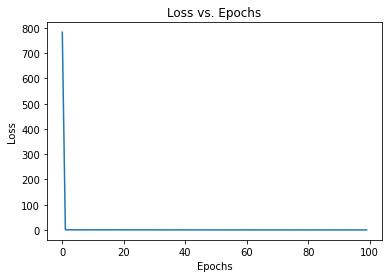

In [ ]:
# Make a plot for the loss

loss_plot = df.plot(y="loss", title = "Loss vs. Epochs", legend=False)
loss_plot.set(xlabel="Epochs", ylabel="Loss")

[Text(0, 0.5, 'binary_accuracy'), Text(0.5, 0, 'Epochs')]

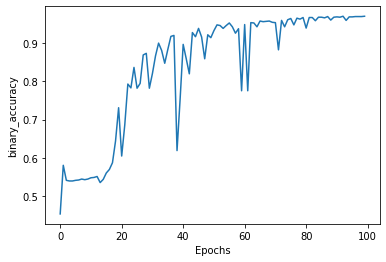

In [ ]:
# Make a plot for the accuracy

accuracy_plot = df.plot(y="binary_accuracy", legend=False)
accuracy_plot.set(xlabel="Epochs", ylabel="binary_accuracy")

In [ ]:
get_train_accuracy(model, X_train, Y_train)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


accuracy: 0.969


In [ ]:
model.evaluate(X_test,Y_test)

13/13 [==============================] - 0s 22ms/step - loss: 0.6463 - binary_accuracy: 0.9100


[0.6462761163711548, 0.9100000262260437]

### #2

In [ ]:
model_2 = Sequential([
                    Conv2D(filters=16, kernel_size=(3,3), strides=(1,1), padding='valid', activation = 'relu', input_shape=(64,64,3)), 
                    Flatten(),
                    Dense(units=64, activation='relu', name='dense_1'),
                    Dense(1, activation = 'sigmoid')
])

In [ ]:
#Adagrad
model_2.compile(
    optimizer = tf.keras.optimizers.Adagrad(learning_rate=0.003), # the default values.
    loss = tf.keras.losses.BinaryCrossentropy(from_logits=True),          # use sigmoid activation, if in the final hidden layer, we do not specify an activation function or define a linear one.
    metrics = [tf.keras.metrics.BinaryAccuracy()]            # default is 0.5 (the threshold for predictions to be classed as positive).
)


In [ ]:
history = model_2.fit(X_train, Y_train, epochs = 150, batch_size = 256, verbose = 2)
df = pd.DataFrame(history.history)

Epoch 1/150


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


5/5 - 2s - loss: 641.8179 - binary_accuracy: 0.4992 - 2s/epoch - 478ms/step
Epoch 2/150
5/5 - 2s - loss: 66.8120 - binary_accuracy: 0.5758 - 2s/epoch - 376ms/step
Epoch 3/150
5/5 - 2s - loss: 0.5894 - binary_accuracy: 0.8283 - 2s/epoch - 373ms/step
Epoch 4/150
5/5 - 2s - loss: 0.4950 - binary_accuracy: 0.8392 - 2s/epoch - 373ms/step
Epoch 5/150
5/5 - 2s - loss: 0.4509 - binary_accuracy: 0.8250 - 2s/epoch - 375ms/step
Epoch 6/150
5/5 - 2s - loss: 0.3957 - binary_accuracy: 0.8208 - 2s/epoch - 373ms/step
Epoch 7/150
5/5 - 2s - loss: 0.3697 - binary_accuracy: 0.8317 - 2s/epoch - 374ms/step
Epoch 8/150
5/5 - 2s - loss: 0.3684 - binary_accuracy: 0.8292 - 2s/epoch - 375ms/step
Epoch 9/150
5/5 - 2s - loss: 0.3141 - binary_accuracy: 0.8333 - 2s/epoch - 377ms/step
Epoch 10/150
5/5 - 2s - loss: 0.3017 - binary_accuracy: 0.8375 - 2s/epoch - 371ms/step
Epoch 11/150
5/5 - 2s - loss: 0.2769 - binary_accuracy: 0.8558 - 2s/epoch - 367ms/step
Epoch 12/150
5/5 - 2s - loss: 0.2554 - binary_accuracy: 0.870

[Text(0, 0.5, 'binary_accuracy'), Text(0.5, 0, 'Epochs')]

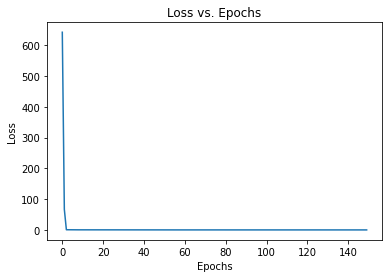

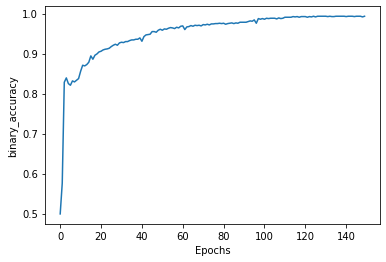

In [ ]:
loss_plot = df.plot(y="loss", title = "Loss vs. Epochs", legend=False)
loss_plot.set(xlabel="Epochs", ylabel="Loss")

# Make a plot for the accuracy

accuracy_plot = df.plot(y="binary_accuracy", legend=False)
accuracy_plot.set(xlabel="Epochs", ylabel="binary_accuracy")

In [ ]:
get_train_accuracy(model_2, X_train, Y_train)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


accuracy: 0.993


In [ ]:
model_2.evaluate(X_test,Y_test)

13/13 [==============================] - 0s 23ms/step - loss: 0.3644 - binary_accuracy: 0.9325


[0.3643577992916107, 0.9325000047683716]

### #3

In [ ]:
model_3 = Sequential([
                    Conv2D(filters=16, kernel_size=(3,3), strides=(1,1), padding='valid', activation = 'relu', input_shape=(64,64,3)), 
                    Flatten(),
                    Dense(units=64, activation='relu', name='dense_1'),
                    Dense(1, activation = 'sigmoid')
])

In [ ]:
#Adagrad
model_3.compile(
    optimizer = tf.keras.optimizers.Adagrad(learning_rate=0.003), # the default values.
    loss = tf.keras.losses.BinaryCrossentropy(from_logits=True),          # use sigmoid activation, if in the final hidden layer, we do not specify an activation function or define a linear one.
    metrics = [tf.keras.metrics.BinaryAccuracy()]            # default is 0.5 (the threshold for predictions to be classed as positive).
)

In [ ]:
history = model_3.fit(X_train, Y_train, epochs =30, batch_size = 256, verbose = 2)
df = pd.DataFrame(history.history)

Epoch 1/30


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


5/5 - 2s - loss: 721.3922 - binary_accuracy: 0.5358 - 2s/epoch - 461ms/step
Epoch 2/30
5/5 - 2s - loss: 0.7046 - binary_accuracy: 0.6175 - 2s/epoch - 376ms/step
Epoch 3/30
5/5 - 2s - loss: 0.6227 - binary_accuracy: 0.6475 - 2s/epoch - 377ms/step
Epoch 4/30
5/5 - 2s - loss: 0.5948 - binary_accuracy: 0.6842 - 2s/epoch - 374ms/step
Epoch 5/30
5/5 - 2s - loss: 0.5516 - binary_accuracy: 0.7450 - 2s/epoch - 377ms/step
Epoch 6/30
5/5 - 2s - loss: 0.5761 - binary_accuracy: 0.7392 - 2s/epoch - 376ms/step
Epoch 7/30
5/5 - 2s - loss: 0.5115 - binary_accuracy: 0.7908 - 2s/epoch - 380ms/step
Epoch 8/30
5/5 - 2s - loss: 0.4961 - binary_accuracy: 0.8058 - 2s/epoch - 376ms/step
Epoch 9/30
5/5 - 2s - loss: 0.5168 - binary_accuracy: 0.7975 - 2s/epoch - 375ms/step
Epoch 10/30
5/5 - 2s - loss: 0.4788 - binary_accuracy: 0.8350 - 2s/epoch - 372ms/step
Epoch 11/30
5/5 - 2s - loss: 0.4892 - binary_accuracy: 0.8100 - 2s/epoch - 379ms/step
Epoch 12/30
5/5 - 2s - loss: 0.4722 - binary_accuracy: 0.8433 - 2s/epoch

[Text(0, 0.5, 'binary_accuracy'), Text(0.5, 0, 'Epochs')]

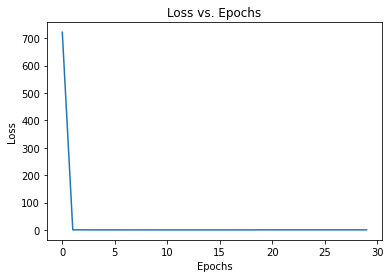

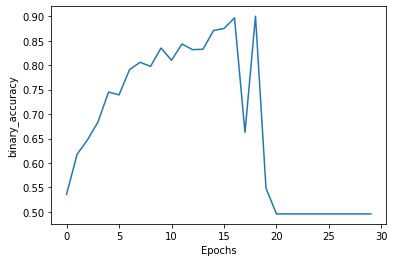

In [ ]:
loss_plot = df.plot(y="loss", title = "Loss vs. Epochs", legend=False)
loss_plot.set(xlabel="Epochs", ylabel="Loss")

# Make a plot for the accuracy

accuracy_plot = df.plot(y="binary_accuracy", legend=False)
accuracy_plot.set(xlabel="Epochs", ylabel="binary_accuracy")

In [ ]:
get_train_accuracy(model_3, X_train, Y_train)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


accuracy: 0.496


In [ ]:
model_3.evaluate(X_test,Y_test)

13/13 [==============================] - 0s 22ms/step - loss: 0.6914 - binary_accuracy: 0.5125


[0.6913939118385315, 0.512499988079071]

## Question2-g Weight Initialization  

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Conv1D, MaxPooling1D 

### #1

In [ ]:
model_g1 = Sequential([
                    Conv2D(filters=16, kernel_size=(3,3), strides=(1,1), padding='valid', activation = 'relu', input_shape=(64,64,3)), 
                    Flatten(),
                    Dense(units=64, activation='relu', name='dense_1',kernel_initializer='random_uniform', bias_initializer='zeros'),
                    Dense(1, activation = 'sigmoid')
])

model_g1.compile(
    optimizer = tf.keras.optimizers.Adagrad(learning_rate=0.003), # the default values.
    loss = tf.keras.losses.BinaryCrossentropy(from_logits=True),          # use sigmoid activation, if in the final hidden layer, we do not specify an activation function or define a linear one.
    metrics = [tf.keras.metrics.BinaryAccuracy()]            # default is 0.5 (the threshold for predictions to be classed as positive).
)

In [ ]:
history = model_g1.fit(X_train, Y_train, epochs =50, batch_size = 256, verbose = 2)

Epoch 1/50


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


5/5 - 2s - loss: 991.9266 - binary_accuracy: 0.5233 - 2s/epoch - 474ms/step
Epoch 2/50
5/5 - 2s - loss: 0.7585 - binary_accuracy: 0.5483 - 2s/epoch - 378ms/step
Epoch 3/50
5/5 - 2s - loss: 0.7394 - binary_accuracy: 0.5383 - 2s/epoch - 397ms/step
Epoch 4/50
5/5 - 2s - loss: 0.7146 - binary_accuracy: 0.5317 - 2s/epoch - 385ms/step
Epoch 5/50
5/5 - 2s - loss: 0.7108 - binary_accuracy: 0.5333 - 2s/epoch - 376ms/step
Epoch 6/50
5/5 - 2s - loss: 0.7126 - binary_accuracy: 0.5350 - 2s/epoch - 379ms/step
Epoch 7/50
5/5 - 2s - loss: 0.7002 - binary_accuracy: 0.5325 - 2s/epoch - 374ms/step
Epoch 8/50
5/5 - 2s - loss: 0.6949 - binary_accuracy: 0.5333 - 2s/epoch - 384ms/step
Epoch 9/50
5/5 - 2s - loss: 0.6883 - binary_accuracy: 0.5325 - 2s/epoch - 377ms/step
Epoch 10/50
5/5 - 2s - loss: 0.6839 - binary_accuracy: 0.5350 - 2s/epoch - 375ms/step
Epoch 11/50
5/5 - 2s - loss: 0.6796 - binary_accuracy: 0.5367 - 2s/epoch - 379ms/step
Epoch 12/50
5/5 - 2s - loss: 0.6765 - binary_accuracy: 0.5367 - 2s/epoch

In [ ]:
get_train_accuracy(model_g1, X_train, Y_train)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


accuracy: 0.910


### #2

In [ ]:
model_g2 = Sequential([
                    Conv2D(filters=16, kernel_size=(3,3), strides=(1,1), padding='valid', activation = 'relu', input_shape=(64,64,3)), 
                    Flatten(),
                    Dense(units=64, activation='relu', name='dense_1', kernel_initializer='truncated_normal', bias_initializer='zeros'),
                    Dense(1, activation = 'sigmoid')
])

initializer = tf.keras.initializers.TruncatedNormal(mean=0., stddev=1.)
layer = tf.keras.layers.Dense(3, kernel_initializer=initializer)

In [ ]:
model_g2.compile(
    optimizer = tf.keras.optimizers.Adagrad(learning_rate=0.003), # the default values.
    loss = tf.keras.losses.BinaryCrossentropy(from_logits=True),          # use sigmoid activation, if in the final hidden layer, we do not specify an activation function or define a linear one.
    metrics = [tf.keras.metrics.BinaryAccuracy()]            # default is 0.5 (the threshold for predictions to be classed as positive).
)

In [ ]:
history = model_g2.fit(X_train, Y_train, epochs =50, batch_size = 256, verbose = 2)

Epoch 1/50
5/5 - 2s - loss: 610.4240 - binary_accuracy: 0.5717 - 2s/epoch - 384ms/step
Epoch 2/50
5/5 - 2s - loss: 289.6202 - binary_accuracy: 0.5767 - 2s/epoch - 387ms/step
Epoch 3/50
5/5 - 2s - loss: 41.2549 - binary_accuracy: 0.8525 - 2s/epoch - 380ms/step
Epoch 4/50
5/5 - 2s - loss: 18.7718 - binary_accuracy: 0.9092 - 2s/epoch - 378ms/step
Epoch 5/50
5/5 - 2s - loss: 15.3183 - binary_accuracy: 0.9150 - 2s/epoch - 378ms/step
Epoch 6/50
5/5 - 3s - loss: 14.2889 - binary_accuracy: 0.9217 - 3s/epoch - 511ms/step
Epoch 7/50
5/5 - 2s - loss: 10.4458 - binary_accuracy: 0.9283 - 2s/epoch - 440ms/step
Epoch 8/50
5/5 - 2s - loss: 8.8631 - binary_accuracy: 0.9325 - 2s/epoch - 379ms/step
Epoch 9/50
5/5 - 2s - loss: 6.9671 - binary_accuracy: 0.9383 - 2s/epoch - 433ms/step
Epoch 10/50
5/5 - 2s - loss: 5.9743 - binary_accuracy: 0.9458 - 2s/epoch - 437ms/step
Epoch 11/50
5/5 - 2s - loss: 5.6221 - binary_accuracy: 0.9500 - 2s/epoch - 374ms/step
Epoch 12/50
5/5 - 2s - loss: 4.5484 - binary_accuracy:

In [ ]:
get_train_accuracy(model_g2, X_train, Y_train)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


accuracy: 1.000


### #3

In [ ]:
model_g3 = Sequential([
                    Conv2D(filters=16, kernel_size=(3,3), strides=(1,1), padding='valid', activation = 'relu', input_shape=(64,64,3)), 
                    Flatten(),
                    Dense(units=64, activation='relu', name='dense_1', kernel_initializer='constant', bias_initializer='zeros'),
                    Dense(1, activation = 'sigmoid')
])

initializer = tf.keras.initializers.Constant(3.)
layer = tf.keras.layers.Dense(3, kernel_initializer=initializer)

In [ ]:
model_g3.compile(
    optimizer = tf.keras.optimizers.Adagrad(learning_rate=0.003), # the default values.
    loss = tf.keras.losses.BinaryCrossentropy(from_logits=True),          # use sigmoid activation, if in the final hidden layer, we do not specify an activation function or define a linear one.
    metrics = [tf.keras.metrics.BinaryAccuracy()]            # default is 0.5 (the threshold for predictions to be classed as positive).
)

In [ ]:
history = model_g3.fit(X_train, Y_train, epochs =50, batch_size = 256, verbose = 2)

Epoch 1/50


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


5/5 - 2s - loss: 0.6931 - binary_accuracy: 0.4925 - 2s/epoch - 474ms/step
Epoch 2/50
5/5 - 2s - loss: 0.6931 - binary_accuracy: 0.5042 - 2s/epoch - 377ms/step
Epoch 3/50
5/5 - 2s - loss: 0.6931 - binary_accuracy: 0.5042 - 2s/epoch - 375ms/step
Epoch 4/50
5/5 - 2s - loss: 0.6932 - binary_accuracy: 0.5042 - 2s/epoch - 385ms/step
Epoch 5/50
5/5 - 2s - loss: 0.6931 - binary_accuracy: 0.5042 - 2s/epoch - 380ms/step
Epoch 6/50
5/5 - 2s - loss: 0.6931 - binary_accuracy: 0.5042 - 2s/epoch - 381ms/step
Epoch 7/50
5/5 - 2s - loss: 0.6931 - binary_accuracy: 0.5042 - 2s/epoch - 377ms/step
Epoch 8/50
5/5 - 2s - loss: 0.6931 - binary_accuracy: 0.5042 - 2s/epoch - 379ms/step
Epoch 9/50
5/5 - 2s - loss: 0.6931 - binary_accuracy: 0.5042 - 2s/epoch - 379ms/step
Epoch 10/50
5/5 - 2s - loss: 0.6931 - binary_accuracy: 0.5042 - 2s/epoch - 381ms/step
Epoch 11/50
5/5 - 2s - loss: 0.6931 - binary_accuracy: 0.5042 - 2s/epoch - 386ms/step
Epoch 12/50
5/5 - 2s - loss: 0.6931 - binary_accuracy: 0.5042 - 2s/epoch -

In [ ]:
get_train_accuracy(model_g3, X_train, Y_train)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


accuracy: 0.504


## Question 3 - Fit Validation Set

In [ ]:
# Introduce function to validation model accuracy

def get_val_accuracy(model, X_val, Y_val):
    val_loss, val_acc = model.evaluate(x=X_val, y=Y_val, verbose=0)
    print('accuracy: {acc:0.3f}'.format(acc=val_acc))

In [ ]:
#3 hidden layers, 64 hidden units, Adagrad, initializer = "truncated_normal"
model_q3 = Sequential([
                    Conv2D(filters=16, kernel_size=(3,3), strides=(1,1), padding='valid', activation = 'relu', input_shape=(64,64,3)), 
                    Flatten(),
                    Dense(units=64, activation='relu', name='dense_1', kernel_initializer='truncated_normal', bias_initializer='zeros'),
                    Dense(1, activation = 'sigmoid')
])

initializer = tf.keras.initializers.TruncatedNormal(mean=0., stddev=1.)
layer = tf.keras.layers.Dense(3, kernel_initializer=initializer)

In [ ]:
model_q3.compile(
    optimizer = tf.keras.optimizers.Adagrad(learning_rate=0.003), # the default values.
    loss = tf.keras.losses.BinaryCrossentropy(from_logits=True),          # use sigmoid activation, if in the final hidden layer, we do not specify an activation function or define a linear one.
    metrics = [tf.keras.metrics.BinaryAccuracy()]            # default is 0.5 (the threshold for predictions to be classed as positive).
)

In [ ]:
#fit validation set
model_q3.fit(X_val, Y_val, epochs = 50, batch_size = 256, verbose = 2)

Epoch 1/50


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


2/2 - 1s - loss: 1372.0245 - binary_accuracy: 0.5400 - 1s/epoch - 543ms/step
Epoch 2/50
2/2 - 1s - loss: 338.0238 - binary_accuracy: 0.6075 - 654ms/epoch - 327ms/step
Epoch 3/50
2/2 - 1s - loss: 0.8743 - binary_accuracy: 0.7600 - 657ms/epoch - 328ms/step
Epoch 4/50
2/2 - 1s - loss: 0.7234 - binary_accuracy: 0.7800 - 642ms/epoch - 321ms/step
Epoch 5/50
2/2 - 1s - loss: 0.6695 - binary_accuracy: 0.7825 - 682ms/epoch - 341ms/step
Epoch 6/50
2/2 - 1s - loss: 0.6346 - binary_accuracy: 0.7875 - 642ms/epoch - 321ms/step
Epoch 7/50
2/2 - 1s - loss: 0.6090 - binary_accuracy: 0.7850 - 638ms/epoch - 319ms/step
Epoch 8/50
2/2 - 1s - loss: 0.5863 - binary_accuracy: 0.7950 - 653ms/epoch - 327ms/step
Epoch 9/50
2/2 - 1s - loss: 0.5721 - binary_accuracy: 0.7950 - 674ms/epoch - 337ms/step
Epoch 10/50
2/2 - 1s - loss: 0.5553 - binary_accuracy: 0.7900 - 658ms/epoch - 329ms/step
Epoch 11/50
2/2 - 1s - loss: 0.5280 - binary_accuracy: 0.8000 - 677ms/epoch - 338ms/step
Epoch 12/50
2/2 - 1s - loss: 0.5096 - b

In [ ]:
get_val_accuracy(model_q3, X_val, Y_val)

accuracy: 0.877


## Question3-b - L2 Regularization

## 1 - penalty rate = 0.001

In [ ]:
#use penalty rate = 0.001
model_3b1 = Sequential([
                    Conv2D(filters=16, kernel_size=(3,3), strides=(1,1), padding='valid', activation = 'relu', input_shape=(64,64,3)), 
                    Flatten(),
                    Dense(units=64, activation='relu', name='dense_1', kernel_initializer='truncated_normal', bias_initializer='zeros',
                          kernel_regularizer=tf.keras.regularizers.l2(0.001)),
                    Dense(1, activation = 'sigmoid')
])

initializer = tf.keras.initializers.TruncatedNormal(mean=0., stddev=1.)
layer = tf.keras.layers.Dense(3, kernel_initializer=initializer)

In [ ]:
model_3b1.compile(
    optimizer = tf.keras.optimizers.Adagrad(learning_rate=0.003), # the default values.
    loss = tf.keras.losses.BinaryCrossentropy(from_logits=True),          # use sigmoid activation, if in the final hidden layer, we do not specify an activation function or define a linear one.
    metrics = [tf.keras.metrics.BinaryAccuracy()]            # default is 0.5 (the threshold for predictions to be classed as positive).
)

In [ ]:
model_3b1.fit(X_test,Y_test,epochs=50,batch_size=256,verbose=2)

Epoch 1/50


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


2/2 - 2s - loss: 893.0531 - binary_accuracy: 0.4275 - 2s/epoch - 1s/step
Epoch 2/50
2/2 - 1s - loss: 967.7866 - binary_accuracy: 0.5300 - 788ms/epoch - 394ms/step
Epoch 3/50
2/2 - 1s - loss: 350.3043 - binary_accuracy: 0.5425 - 801ms/epoch - 400ms/step
Epoch 4/50
2/2 - 1s - loss: 318.0938 - binary_accuracy: 0.4950 - 781ms/epoch - 391ms/step
Epoch 5/50
2/2 - 1s - loss: 212.9472 - binary_accuracy: 0.5650 - 795ms/epoch - 397ms/step
Epoch 6/50
2/2 - 1s - loss: 82.9605 - binary_accuracy: 0.7575 - 772ms/epoch - 386ms/step
Epoch 7/50
2/2 - 1s - loss: 129.2879 - binary_accuracy: 0.5900 - 777ms/epoch - 389ms/step
Epoch 8/50
2/2 - 1s - loss: 44.6092 - binary_accuracy: 0.8200 - 775ms/epoch - 387ms/step
Epoch 9/50
2/2 - 1s - loss: 24.0750 - binary_accuracy: 0.8975 - 788ms/epoch - 394ms/step
Epoch 10/50
2/2 - 1s - loss: 21.6509 - binary_accuracy: 0.9125 - 790ms/epoch - 395ms/step
Epoch 11/50
2/2 - 1s - loss: 18.6587 - binary_accuracy: 0.9250 - 791ms/epoch - 395ms/step
Epoch 12/50
2/2 - 1s - loss: 1

In [ ]:
def get_test_accuracy(model, X_test, Y_test):
    test_loss, test_acc = model.evaluate(x=X_test, y=Y_test, verbose=0)
    print('accuracy: {acc:0.3f}'.format(acc=test_acc))

In [ ]:
get_test_accuracy(model_3b1,X_test,Y_test)

accuracy: 0.998


In [ ]:
model_3b1.fit(X_train,Y_train,epochs=50,batch_size=256,verbose=2)

Epoch 1/50
5/5 - 3s - loss: 31.6382 - binary_accuracy: 0.8217 - 3s/epoch - 541ms/step
Epoch 2/50
5/5 - 2s - loss: 119.8648 - binary_accuracy: 0.6467 - 2s/epoch - 439ms/step
Epoch 3/50
5/5 - 2s - loss: 17.8326 - binary_accuracy: 0.9192 - 2s/epoch - 435ms/step
Epoch 4/50
5/5 - 2s - loss: 15.6788 - binary_accuracy: 0.9217 - 2s/epoch - 443ms/step
Epoch 5/50
5/5 - 2s - loss: 13.9364 - binary_accuracy: 0.9342 - 2s/epoch - 440ms/step
Epoch 6/50
5/5 - 2s - loss: 12.5852 - binary_accuracy: 0.9408 - 2s/epoch - 444ms/step
Epoch 7/50
5/5 - 2s - loss: 14.1439 - binary_accuracy: 0.9317 - 2s/epoch - 439ms/step
Epoch 8/50
5/5 - 2s - loss: 11.0270 - binary_accuracy: 0.9475 - 2s/epoch - 444ms/step
Epoch 9/50
5/5 - 2s - loss: 9.9995 - binary_accuracy: 0.9583 - 2s/epoch - 443ms/step
Epoch 10/50
5/5 - 2s - loss: 9.8869 - binary_accuracy: 0.9625 - 2s/epoch - 430ms/step
Epoch 11/50
5/5 - 2s - loss: 8.9817 - binary_accuracy: 0.9692 - 2s/epoch - 446ms/step
Epoch 12/50
5/5 - 2s - loss: 8.7333 - binary_accuracy:

In [ ]:
get_train_accuracy(model_3b1,X_train,Y_train)

accuracy: 1.000


In [ ]:
#concat training and validation sets to a temporary one
temp_x = np.concatenate((X_train,X_val),axis=0)
temp_y = np.concatenate((Y_train,Y_val),axis=0)


In [ ]:
history = model_3b1.fit(temp_x,temp_y,epochs=50,batch_size=256,verbose=2,validation_split=0.25)

Epoch 1/50
5/5 - 2s - loss: 12.5489 - binary_accuracy: 0.8892 - val_loss: 8.0349 - val_binary_accuracy: 0.9750 - 2s/epoch - 458ms/step
Epoch 2/50
5/5 - 2s - loss: 11.4232 - binary_accuracy: 0.9042 - val_loss: 10.3074 - val_binary_accuracy: 0.8925 - 2s/epoch - 440ms/step
Epoch 3/50
5/5 - 2s - loss: 14.1222 - binary_accuracy: 0.8625 - val_loss: 7.7348 - val_binary_accuracy: 0.9875 - 2s/epoch - 441ms/step
Epoch 4/50
5/5 - 2s - loss: 10.0700 - binary_accuracy: 0.9217 - val_loss: 8.9208 - val_binary_accuracy: 0.9250 - 2s/epoch - 443ms/step
Epoch 5/50
5/5 - 2s - loss: 9.8016 - binary_accuracy: 0.9250 - val_loss: 7.8296 - val_binary_accuracy: 0.9775 - 2s/epoch - 442ms/step
Epoch 6/50
5/5 - 2s - loss: 8.9603 - binary_accuracy: 0.9475 - val_loss: 7.8384 - val_binary_accuracy: 0.9925 - 2s/epoch - 442ms/step
Epoch 7/50
5/5 - 2s - loss: 8.5496 - binary_accuracy: 0.9567 - val_loss: 7.8178 - val_binary_accuracy: 0.9925 - 2s/epoch - 444ms/step
Epoch 8/50
5/5 - 2s - loss: 8.3010 - binary_accuracy: 0.9

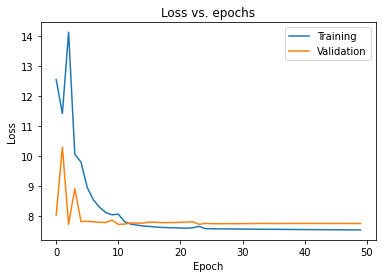

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

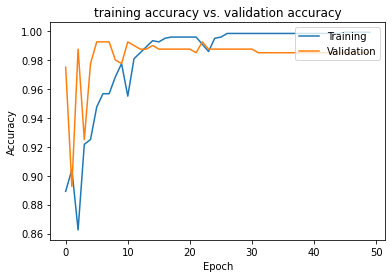

In [ ]:
plt.plot(history.history['binary_accuracy'])
plt.plot(history.history['val_binary_accuracy'])
plt.title('training accuracy vs. validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

In [ ]:
get_val_accuracy(model_3b1, X_val, Y_val)

accuracy: 0.985


## 2 - penalty rate = 0.005

In [ ]:
#use penalty rate = 0.005
model_3b2 = Sequential([
                    Conv2D(filters=16, kernel_size=(3,3), strides=(1,1), padding='valid', activation = 'relu', input_shape=(64,64,3)), 
                    Flatten(),
                    Dense(units=64, activation='relu', name='dense_1', kernel_initializer='truncated_normal', bias_initializer='zeros',
                          kernel_regularizer=tf.keras.regularizers.l2(0.005)),
                    Dense(1, activation = 'sigmoid')
])

initializer = tf.keras.initializers.TruncatedNormal(mean=0., stddev=1.)
layer = tf.keras.layers.Dense(3, kernel_initializer=initializer)

In [ ]:
model_3b2.compile(
    optimizer = tf.keras.optimizers.Adagrad(learning_rate=0.003), # the default values.
    loss = tf.keras.losses.BinaryCrossentropy(from_logits=True),          # use sigmoid activation, if in the final hidden layer, we do not specify an activation function or define a linear one.
    metrics = [tf.keras.metrics.BinaryAccuracy()]            # default is 0.5 (the threshold for predictions to be classed as positive).
)

In [ ]:
history = model_3b2.fit(temp_x,temp_y,epochs=50,batch_size=256,verbose=2,validation_split=0.25)

Epoch 1/50
5/5 - 2s - loss: 39.1103 - binary_accuracy: 0.6375 - val_loss: 39.3361 - val_binary_accuracy: 0.6150 - 2s/epoch - 453ms/step
Epoch 2/50
5/5 - 2s - loss: 38.9358 - binary_accuracy: 0.6258 - val_loss: 39.1921 - val_binary_accuracy: 0.6125 - 2s/epoch - 452ms/step
Epoch 3/50
5/5 - 2s - loss: 38.8544 - binary_accuracy: 0.6233 - val_loss: 39.1292 - val_binary_accuracy: 0.6200 - 2s/epoch - 454ms/step
Epoch 4/50
5/5 - 2s - loss: 38.8025 - binary_accuracy: 0.6267 - val_loss: 39.0478 - val_binary_accuracy: 0.6150 - 2s/epoch - 452ms/step
Epoch 5/50
5/5 - 4s - loss: 38.7475 - binary_accuracy: 0.6192 - val_loss: 38.9810 - val_binary_accuracy: 0.6100 - 4s/epoch - 845ms/step
Epoch 6/50
5/5 - 2s - loss: 38.7019 - binary_accuracy: 0.6217 - val_loss: 38.9599 - val_binary_accuracy: 0.6100 - 2s/epoch - 450ms/step
Epoch 7/50
5/5 - 2s - loss: 38.6604 - binary_accuracy: 0.6242 - val_loss: 38.9326 - val_binary_accuracy: 0.6150 - 2s/epoch - 449ms/step
Epoch 8/50
5/5 - 2s - loss: 38.6197 - binary_acc

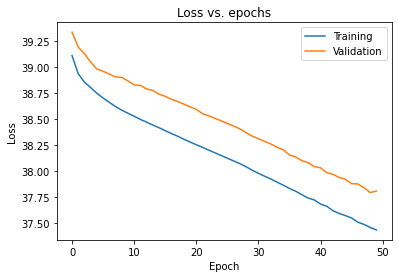

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

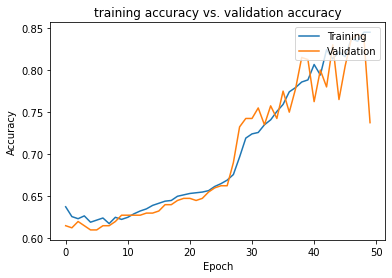

In [ ]:
plt.plot(history.history['binary_accuracy'])
plt.plot(history.history['val_binary_accuracy'])
plt.title('training accuracy vs. validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

In [ ]:
get_val_accuracy(model_3b2, X_val, Y_val)

accuracy: 0.738


## 3 - penalty rate = 0.01

In [ ]:
#use penalty rate = 0.01
model_3b3 = Sequential([
                    Conv2D(filters=16, kernel_size=(3,3), strides=(1,1), padding='valid', activation = 'relu', input_shape=(64,64,3)), 
                    Flatten(),
                    Dense(units=64, activation='relu', name='dense_1', kernel_initializer='truncated_normal', bias_initializer='zeros',
                          kernel_regularizer=tf.keras.regularizers.l2(0.01)),
                    Dense(1, activation = 'sigmoid')
])

initializer = tf.keras.initializers.TruncatedNormal(mean=0., stddev=1.)
layer = tf.keras.layers.Dense(3, kernel_initializer=initializer)

model_3b3.compile(
    optimizer = tf.keras.optimizers.Adagrad(learning_rate=0.003), # the default values.
    loss = tf.keras.losses.BinaryCrossentropy(from_logits=True),          # use sigmoid activation, if in the final hidden layer, we do not specify an activation function or define a linear one.
    metrics = [tf.keras.metrics.BinaryAccuracy()]            # default is 0.5 (the threshold for predictions to be classed as positive).
)

In [ ]:
history = model_3b3.fit(temp_x,temp_y,epochs=50,batch_size=256,verbose=2,validation_split=0.25)

Epoch 1/50


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


5/5 - 3s - loss: 2366.5474 - binary_accuracy: 0.5033 - val_loss: 124.5055 - val_binary_accuracy: 0.5450 - 3s/epoch - 583ms/step
Epoch 2/50
5/5 - 2s - loss: 114.6044 - binary_accuracy: 0.5617 - val_loss: 113.4488 - val_binary_accuracy: 0.5500 - 2s/epoch - 452ms/step
Epoch 3/50
5/5 - 2s - loss: 90.0984 - binary_accuracy: 0.7242 - val_loss: 94.2571 - val_binary_accuracy: 0.6350 - 2s/epoch - 451ms/step
Epoch 4/50
5/5 - 2s - loss: 86.1689 - binary_accuracy: 0.7467 - val_loss: 83.8707 - val_binary_accuracy: 0.7625 - 2s/epoch - 453ms/step
Epoch 5/50
5/5 - 2s - loss: 81.1913 - binary_accuracy: 0.8308 - val_loss: 83.0532 - val_binary_accuracy: 0.7425 - 2s/epoch - 450ms/step
Epoch 6/50
5/5 - 2s - loss: 79.9772 - binary_accuracy: 0.8375 - val_loss: 80.6517 - val_binary_accuracy: 0.8000 - 2s/epoch - 455ms/step
Epoch 7/50
5/5 - 2s - loss: 78.7971 - binary_accuracy: 0.8725 - val_loss: 79.3549 - val_binary_accuracy: 0.8175 - 2s/epoch - 447ms/step
Epoch 8/50
5/5 - 2s - loss: 77.8378 - binary_accuracy:

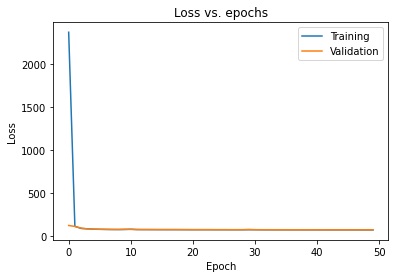

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

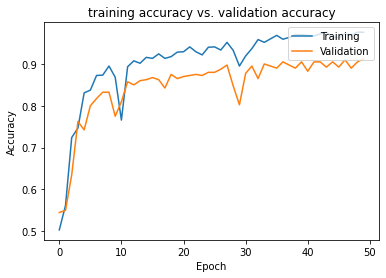

In [ ]:
plt.plot(history.history['binary_accuracy'])
plt.plot(history.history['val_binary_accuracy'])
plt.title('training accuracy vs. validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

In [ ]:
get_val_accuracy(model_3b3, X_val, Y_val)

accuracy: 0.913


## 4 - penalty rate = 0.05

In [ ]:
#use penalty rate = 0.05
model_3b4 = Sequential([
                    Conv2D(filters=16, kernel_size=(3,3), strides=(1,1), padding='valid', activation = 'relu', input_shape=(64,64,3)), 
                    Flatten(),
                    Dense(units=64, activation='relu', name='dense_1', kernel_initializer='truncated_normal', bias_initializer='zeros',
                          kernel_regularizer=tf.keras.regularizers.l2(0.01)),
                    Dense(1, activation = 'sigmoid')
])

initializer = tf.keras.initializers.TruncatedNormal(mean=0., stddev=1.)
layer = tf.keras.layers.Dense(3, kernel_initializer=initializer)

model_3b4.compile(
    optimizer = tf.keras.optimizers.Adagrad(learning_rate=0.003), # the default values.
    loss = tf.keras.losses.BinaryCrossentropy(from_logits=True),          # use sigmoid activation, if in the final hidden layer, we do not specify an activation function or define a linear one.
    metrics = [tf.keras.metrics.BinaryAccuracy()]            # default is 0.5 (the threshold for predictions to be classed as positive).
)

In [ ]:
history = model_3b4.fit(temp_x,temp_y,epochs=50,batch_size=256,verbose=2,validation_split=0.25)

Epoch 1/50


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


5/5 - 3s - loss: 2624.3501 - binary_accuracy: 0.5425 - val_loss: 77.0221 - val_binary_accuracy: 0.5725 - 3s/epoch - 584ms/step
Epoch 2/50
5/5 - 2s - loss: 77.0761 - binary_accuracy: 0.5658 - val_loss: 76.8752 - val_binary_accuracy: 0.5700 - 2s/epoch - 448ms/step
Epoch 3/50
5/5 - 2s - loss: 76.9033 - binary_accuracy: 0.5608 - val_loss: 76.7729 - val_binary_accuracy: 0.5600 - 2s/epoch - 442ms/step
Epoch 4/50
5/5 - 2s - loss: 76.7529 - binary_accuracy: 0.5575 - val_loss: 76.6907 - val_binary_accuracy: 0.5550 - 2s/epoch - 453ms/step
Epoch 5/50
5/5 - 3s - loss: 76.6371 - binary_accuracy: 0.5600 - val_loss: 76.6116 - val_binary_accuracy: 0.5450 - 3s/epoch - 563ms/step
Epoch 6/50
5/5 - 2s - loss: 76.5288 - binary_accuracy: 0.5567 - val_loss: 76.5290 - val_binary_accuracy: 0.5450 - 2s/epoch - 449ms/step
Epoch 7/50
5/5 - 3s - loss: 76.4267 - binary_accuracy: 0.5542 - val_loss: 76.6472 - val_binary_accuracy: 0.5425 - 3s/epoch - 588ms/step
Epoch 8/50
5/5 - 3s - loss: 76.3192 - binary_accuracy: 0.

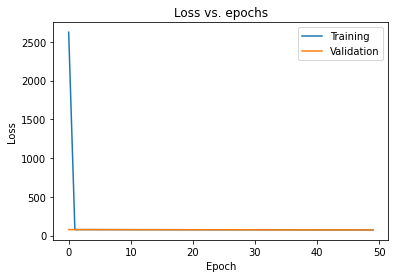

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

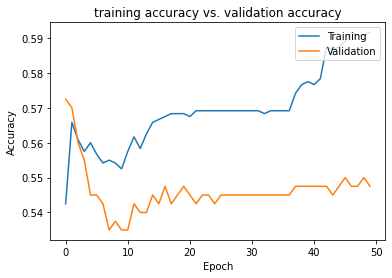

In [ ]:
plt.plot(history.history['binary_accuracy'])
plt.plot(history.history['val_binary_accuracy'])
plt.title('training accuracy vs. validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

In [ ]:
get_val_accuracy(model_3b4, X_val, Y_val)

accuracy: 0.548


## 5 - penalty rate = 0.1

In [ ]:
#use penalty rate = 0.1
model_3b5 = Sequential([
                    Conv2D(filters=16, kernel_size=(3,3), strides=(1,1), padding='valid', activation = 'relu', input_shape=(64,64,3)), 
                    Flatten(),
                    Dense(units=64, activation='relu', name='dense_1', kernel_initializer='truncated_normal', bias_initializer='zeros',
                          kernel_regularizer=tf.keras.regularizers.l2(0.01)),
                    Dense(1, activation = 'sigmoid')
])

initializer = tf.keras.initializers.TruncatedNormal(mean=0., stddev=1.)
layer = tf.keras.layers.Dense(3, kernel_initializer=initializer)

model_3b5.compile(
    optimizer = tf.keras.optimizers.Adagrad(learning_rate=0.003), # the default values.
    loss = tf.keras.losses.BinaryCrossentropy(from_logits=True),          # use sigmoid activation, if in the final hidden layer, we do not specify an activation function or define a linear one.
    metrics = [tf.keras.metrics.BinaryAccuracy()]            # default is 0.5 (the threshold for predictions to be classed as positive).
)

In [ ]:
history = model_3b5.fit(temp_x,temp_y,epochs=50,batch_size=256,verbose=2,validation_split=0.25)

Epoch 1/50


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


5/5 - 3s - loss: 690.5285 - binary_accuracy: 0.4992 - val_loss: 77.1810 - val_binary_accuracy: 0.4900 - 3s/epoch - 605ms/step
Epoch 2/50
5/5 - 2s - loss: 76.8272 - binary_accuracy: 0.5400 - val_loss: 76.9041 - val_binary_accuracy: 0.5200 - 2s/epoch - 451ms/step
Epoch 3/50
5/5 - 2s - loss: 76.6194 - binary_accuracy: 0.5508 - val_loss: 76.7043 - val_binary_accuracy: 0.5200 - 2s/epoch - 450ms/step
Epoch 4/50
5/5 - 2s - loss: 76.4448 - binary_accuracy: 0.5625 - val_loss: 76.5550 - val_binary_accuracy: 0.5200 - 2s/epoch - 454ms/step
Epoch 5/50
5/5 - 2s - loss: 76.2927 - binary_accuracy: 0.5658 - val_loss: 76.4151 - val_binary_accuracy: 0.5300 - 2s/epoch - 455ms/step
Epoch 6/50
5/5 - 2s - loss: 76.1406 - binary_accuracy: 0.5675 - val_loss: 76.2899 - val_binary_accuracy: 0.5225 - 2s/epoch - 460ms/step
Epoch 7/50
5/5 - 2s - loss: 75.9924 - binary_accuracy: 0.5692 - val_loss: 76.1682 - val_binary_accuracy: 0.5250 - 2s/epoch - 451ms/step
Epoch 8/50
5/5 - 2s - loss: 75.8444 - binary_accuracy: 0.5

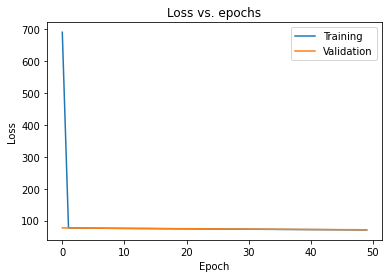

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

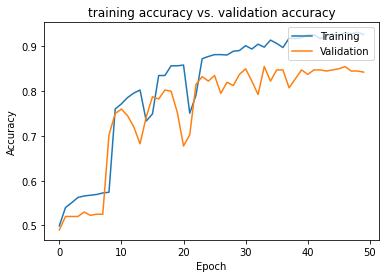

In [ ]:
plt.plot(history.history['binary_accuracy'])
plt.plot(history.history['val_binary_accuracy'])
plt.title('training accuracy vs. validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

In [ ]:
get_val_accuracy(model_3b5, X_val, Y_val)

accuracy: 0.842


## Question3c - Dropout Regularization

## 1- dropout = 0.5

In [ ]:
model_3c1 = Sequential([
                    Conv2D(filters=16, kernel_size=(3,3), strides=(1,1), padding='valid', activation = 'relu', input_shape=(64,64,3)), 
                    Flatten(),
                    Dense(units=64, activation='relu', name='dense_1', kernel_initializer='truncated_normal', bias_initializer='zeros',
                          kernel_regularizer=tf.keras.regularizers.l2(0.001)),
                    Dropout(0.5),
                    Dense(1, activation = 'sigmoid')
])

initializer = tf.keras.initializers.TruncatedNormal(mean=0., stddev=1.)
layer = tf.keras.layers.Dense(3, kernel_initializer=initializer)

model_3c1.compile(
    optimizer = tf.keras.optimizers.Adagrad(learning_rate=0.003), # the default values.
    loss = tf.keras.losses.BinaryCrossentropy(from_logits=True),          # use sigmoid activation, if in the final hidden layer, we do not specify an activation function or define a linear one.
    metrics = [tf.keras.metrics.BinaryAccuracy()]            # default is 0.5 (the threshold for predictions to be classed as positive).
)

In [ ]:
history = model_3c1.fit(temp_x,temp_y,epochs=50,batch_size=256,verbose=2,validation_split=0.25)

Epoch 1/50


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


5/5 - 3s - loss: 875.3720 - binary_accuracy: 0.5400 - val_loss: 126.1629 - val_binary_accuracy: 0.5200 - 3s/epoch - 596ms/step
Epoch 2/50
5/5 - 2s - loss: 100.0382 - binary_accuracy: 0.6475 - val_loss: 14.4239 - val_binary_accuracy: 0.8675 - 2s/epoch - 449ms/step
Epoch 3/50
5/5 - 2s - loss: 17.3323 - binary_accuracy: 0.8017 - val_loss: 10.1020 - val_binary_accuracy: 0.8150 - 2s/epoch - 456ms/step
Epoch 4/50
5/5 - 3s - loss: 10.0827 - binary_accuracy: 0.8050 - val_loss: 8.9698 - val_binary_accuracy: 0.7875 - 3s/epoch - 644ms/step
Epoch 5/50
5/5 - 2s - loss: 9.0762 - binary_accuracy: 0.7333 - val_loss: 8.6410 - val_binary_accuracy: 0.7550 - 2s/epoch - 459ms/step
Epoch 6/50
5/5 - 3s - loss: 8.9840 - binary_accuracy: 0.7317 - val_loss: 8.4673 - val_binary_accuracy: 0.7850 - 3s/epoch - 677ms/step
Epoch 7/50
5/5 - 3s - loss: 8.5061 - binary_accuracy: 0.7258 - val_loss: 8.4564 - val_binary_accuracy: 0.8250 - 3s/epoch - 591ms/step
Epoch 8/50
5/5 - 3s - loss: 8.5420 - binary_accuracy: 0.7592 - 

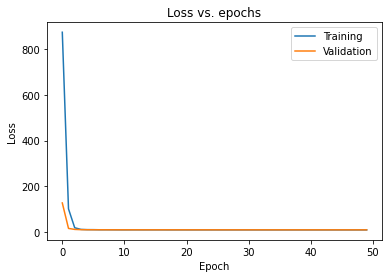

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

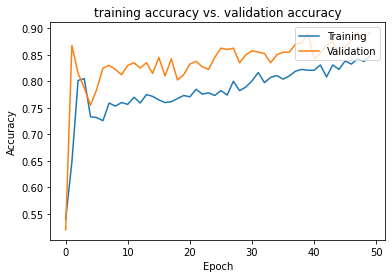

In [ ]:
plt.plot(history.history['binary_accuracy'])
plt.plot(history.history['val_binary_accuracy'])
plt.title('training accuracy vs. validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

In [ ]:
get_val_accuracy(model_3c1, X_val, Y_val)

accuracy: 0.892


## 2- dropout = 0.1

In [ ]:
model_3c2 = Sequential([
                    Conv2D(filters=16, kernel_size=(3,3), strides=(1,1), padding='valid', activation = 'relu', input_shape=(64,64,3)), 
                    Flatten(),
                    Dense(units=64, activation='relu', name='dense_1', kernel_initializer='truncated_normal', bias_initializer='zeros',
                          kernel_regularizer=tf.keras.regularizers.l2(0.001)),
                    Dropout(0.1),
                    Dense(1, activation = 'sigmoid')
])

initializer = tf.keras.initializers.TruncatedNormal(mean=0., stddev=1.)
layer = tf.keras.layers.Dense(3, kernel_initializer=initializer)

model_3c2.compile(
    optimizer = tf.keras.optimizers.Adagrad(learning_rate=0.003), # the default values.
    loss = tf.keras.losses.BinaryCrossentropy(from_logits=True),          # use sigmoid activation, if in the final hidden layer, we do not specify an activation function or define a linear one.
    metrics = [tf.keras.metrics.BinaryAccuracy()]            # default is 0.5 (the threshold for predictions to be classed as positive).
)

In [ ]:
history = model_3c2.fit(temp_x,temp_y,epochs=50,batch_size=256,verbose=2,validation_split=0.25)

Epoch 1/50


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


5/5 - 3s - loss: 1601.9418 - binary_accuracy: 0.5108 - val_loss: 23.1046 - val_binary_accuracy: 0.4975 - 3s/epoch - 700ms/step
Epoch 2/50
5/5 - 2s - loss: 12.1363 - binary_accuracy: 0.5742 - val_loss: 8.6776 - val_binary_accuracy: 0.6050 - 2s/epoch - 455ms/step
Epoch 3/50
5/5 - 2s - loss: 8.4976 - binary_accuracy: 0.6117 - val_loss: 8.5523 - val_binary_accuracy: 0.5775 - 2s/epoch - 449ms/step
Epoch 4/50
5/5 - 3s - loss: 8.3783 - binary_accuracy: 0.5917 - val_loss: 8.5113 - val_binary_accuracy: 0.5725 - 3s/epoch - 679ms/step
Epoch 5/50
5/5 - 3s - loss: 8.3515 - binary_accuracy: 0.5750 - val_loss: 8.4832 - val_binary_accuracy: 0.5750 - 3s/epoch - 631ms/step
Epoch 6/50
5/5 - 2s - loss: 8.3121 - binary_accuracy: 0.5908 - val_loss: 8.4753 - val_binary_accuracy: 0.5700 - 2s/epoch - 452ms/step
Epoch 7/50
5/5 - 2s - loss: 8.2929 - binary_accuracy: 0.5867 - val_loss: 8.4694 - val_binary_accuracy: 0.5725 - 2s/epoch - 453ms/step
Epoch 8/50
5/5 - 2s - loss: 8.2901 - binary_accuracy: 0.5717 - val_l

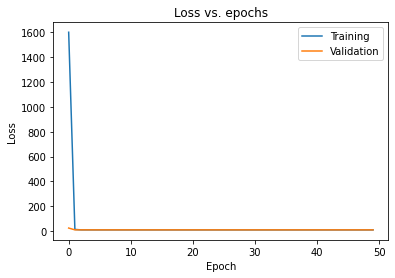

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

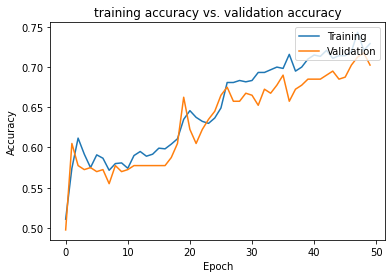

In [ ]:
plt.plot(history.history['binary_accuracy'])
plt.plot(history.history['val_binary_accuracy'])
plt.title('training accuracy vs. validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

In [ ]:
get_val_accuracy(model_3c2, X_val, Y_val)

accuracy: 0.702


## 3 - dropout = 0.25

In [ ]:
model_3c3 = Sequential([
                    Conv2D(filters=16, kernel_size=(3,3), strides=(1,1), padding='valid', activation = 'relu', input_shape=(64,64,3)), 
                    Flatten(),
                    Dense(units=64, activation='relu', name='dense_1', kernel_initializer='truncated_normal', bias_initializer='zeros',
                          kernel_regularizer=tf.keras.regularizers.l2(0.001)),
                    Dropout(0.25),
                    Dense(1, activation = 'sigmoid')
])

initializer = tf.keras.initializers.TruncatedNormal(mean=0., stddev=1.)
layer = tf.keras.layers.Dense(3, kernel_initializer=initializer)

model_3c3.compile(
    optimizer = tf.keras.optimizers.Adagrad(learning_rate=0.003), # the default values.
    loss = tf.keras.losses.BinaryCrossentropy(from_logits=True),          # use sigmoid activation, if in the final hidden layer, we do not specify an activation function or define a linear one.
    metrics = [tf.keras.metrics.BinaryAccuracy()]            # default is 0.5 (the threshold for predictions to be classed as positive).
)

In [ ]:
history = model_3c3.fit(temp_x,temp_y,epochs=50,batch_size=256,verbose=2,validation_split=0.25)

Epoch 1/50


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


5/5 - 3s - loss: 1308.3093 - binary_accuracy: 0.5300 - val_loss: 8.4793 - val_binary_accuracy: 0.5825 - 3s/epoch - 595ms/step
Epoch 2/50
5/5 - 2s - loss: 8.4791 - binary_accuracy: 0.5608 - val_loss: 8.3832 - val_binary_accuracy: 0.5650 - 2s/epoch - 472ms/step
Epoch 3/50
5/5 - 3s - loss: 8.3941 - binary_accuracy: 0.5558 - val_loss: 8.3523 - val_binary_accuracy: 0.5750 - 3s/epoch - 621ms/step
Epoch 4/50
5/5 - 2s - loss: 8.3668 - binary_accuracy: 0.5708 - val_loss: 8.3401 - val_binary_accuracy: 0.5850 - 2s/epoch - 464ms/step
Epoch 5/50
5/5 - 2s - loss: 8.4025 - binary_accuracy: 0.5742 - val_loss: 8.3344 - val_binary_accuracy: 0.5925 - 2s/epoch - 457ms/step
Epoch 6/50
5/5 - 2s - loss: 8.3545 - binary_accuracy: 0.5842 - val_loss: 8.3278 - val_binary_accuracy: 0.6050 - 2s/epoch - 454ms/step
Epoch 7/50
5/5 - 2s - loss: 8.3427 - binary_accuracy: 0.5958 - val_loss: 8.3150 - val_binary_accuracy: 0.6100 - 2s/epoch - 460ms/step
Epoch 8/50
5/5 - 2s - loss: 8.3137 - binary_accuracy: 0.5908 - val_los

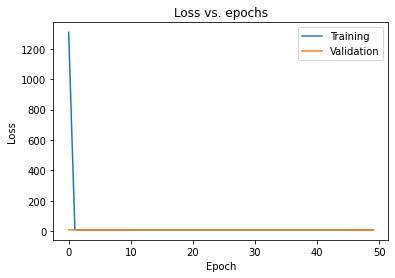

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

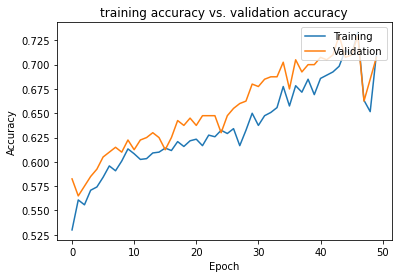

In [ ]:
plt.plot(history.history['binary_accuracy'])
plt.plot(history.history['val_binary_accuracy'])
plt.title('training accuracy vs. validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

In [ ]:
get_val_accuracy(model_3c3, X_val, Y_val)

accuracy: 0.707


## 4 - dropout = 0.99

In [ ]:
model_3c4 = Sequential([
                    Conv2D(filters=16, kernel_size=(3,3), strides=(1,1), padding='valid', activation = 'relu', input_shape=(64,64,3)), 
                    Flatten(),
                    Dense(units=64, activation='relu', name='dense_1', kernel_initializer='truncated_normal', bias_initializer='zeros',
                          kernel_regularizer=tf.keras.regularizers.l2(0.001)),
                    Dropout(0.99),
                    Dense(1, activation = 'sigmoid')
])

initializer = tf.keras.initializers.TruncatedNormal(mean=0., stddev=1.)
layer = tf.keras.layers.Dense(3, kernel_initializer=initializer)

model_3c4.compile(
    optimizer = tf.keras.optimizers.Adagrad(learning_rate=0.003), # the default values.
    loss = tf.keras.losses.BinaryCrossentropy(from_logits=True),          # use sigmoid activation, if in the final hidden layer, we do not specify an activation function or define a linear one.
    metrics = [tf.keras.metrics.BinaryAccuracy()]            # default is 0.5 (the threshold for predictions to be classed as positive).
)

In [ ]:
history = model_3c4.fit(temp_x,temp_y,epochs=50,batch_size=256,verbose=2,validation_split=0.25)

Epoch 1/50


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


5/5 - 4s - loss: 397.4547 - binary_accuracy: 0.4875 - val_loss: 14.9407 - val_binary_accuracy: 0.4450 - 4s/epoch - 702ms/step
Epoch 2/50
5/5 - 2s - loss: 11.9121 - binary_accuracy: 0.5050 - val_loss: 9.0408 - val_binary_accuracy: 0.5000 - 2s/epoch - 454ms/step
Epoch 3/50
5/5 - 2s - loss: 9.6803 - binary_accuracy: 0.5025 - val_loss: 8.7847 - val_binary_accuracy: 0.5075 - 2s/epoch - 458ms/step
Epoch 4/50
5/5 - 2s - loss: 8.3705 - binary_accuracy: 0.5033 - val_loss: 8.7919 - val_binary_accuracy: 0.5050 - 2s/epoch - 460ms/step
Epoch 5/50
5/5 - 2s - loss: 9.4710 - binary_accuracy: 0.5050 - val_loss: 8.5410 - val_binary_accuracy: 0.5025 - 2s/epoch - 457ms/step
Epoch 6/50
5/5 - 2s - loss: 8.6419 - binary_accuracy: 0.5042 - val_loss: 8.5434 - val_binary_accuracy: 0.5025 - 2s/epoch - 453ms/step
Epoch 7/50
5/5 - 2s - loss: 8.5685 - binary_accuracy: 0.5050 - val_loss: 8.4045 - val_binary_accuracy: 0.5050 - 2s/epoch - 461ms/step
Epoch 8/50
5/5 - 2s - loss: 8.3130 - binary_accuracy: 0.5042 - val_lo

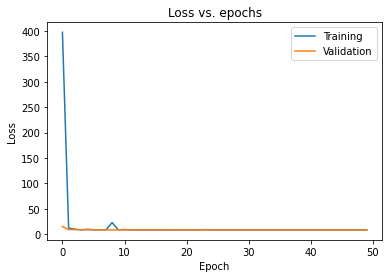

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

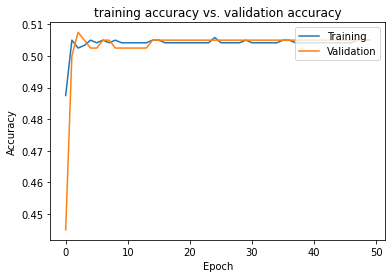

In [ ]:
plt.plot(history.history['binary_accuracy'])
plt.plot(history.history['val_binary_accuracy'])
plt.title('training accuracy vs. validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

In [ ]:
get_val_accuracy(model_3c4, X_val, Y_val)

accuracy: 0.505


## 5 - dropout = 0.75

In [ ]:
model_3c5 = Sequential([
                    Conv2D(filters=16, kernel_size=(3,3), strides=(1,1), padding='valid', activation = 'relu', input_shape=(64,64,3)), 
                    Flatten(),
                    Dense(units=64, activation='relu', name='dense_1', kernel_initializer='truncated_normal', bias_initializer='zeros',
                          kernel_regularizer=tf.keras.regularizers.l2(0.001)),
                    Dropout(0.75),
                    Dense(1, activation = 'sigmoid')
])

initializer = tf.keras.initializers.TruncatedNormal(mean=0., stddev=1.)
layer = tf.keras.layers.Dense(3, kernel_initializer=initializer)

model_3c5.compile(
    optimizer = tf.keras.optimizers.Adagrad(learning_rate=0.003), # the default values.
    loss = tf.keras.losses.BinaryCrossentropy(from_logits=True),          # use sigmoid activation, if in the final hidden layer, we do not specify an activation function or define a linear one.
    metrics = [tf.keras.metrics.BinaryAccuracy()]            # default is 0.5 (the threshold for predictions to be classed as positive).
)

In [ ]:
history = model_3c5.fit(temp_x,temp_y,epochs=50,batch_size=256,verbose=2,validation_split=0.25)

Epoch 1/50


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


5/5 - 3s - loss: 321.2784 - binary_accuracy: 0.5658 - val_loss: 9.6240 - val_binary_accuracy: 0.8175 - 3s/epoch - 631ms/step
Epoch 2/50
5/5 - 2s - loss: 9.0954 - binary_accuracy: 0.7042 - val_loss: 8.6111 - val_binary_accuracy: 0.7950 - 2s/epoch - 459ms/step
Epoch 3/50
5/5 - 2s - loss: 8.4014 - binary_accuracy: 0.6858 - val_loss: 8.4245 - val_binary_accuracy: 0.7775 - 2s/epoch - 465ms/step
Epoch 4/50
5/5 - 2s - loss: 8.3644 - binary_accuracy: 0.6833 - val_loss: 8.3569 - val_binary_accuracy: 0.7950 - 2s/epoch - 453ms/step
Epoch 5/50
5/5 - 2s - loss: 8.2970 - binary_accuracy: 0.6875 - val_loss: 8.4091 - val_binary_accuracy: 0.7825 - 2s/epoch - 455ms/step
Epoch 6/50
5/5 - 2s - loss: 8.3214 - binary_accuracy: 0.6633 - val_loss: 8.3194 - val_binary_accuracy: 0.7825 - 2s/epoch - 454ms/step
Epoch 7/50
5/5 - 2s - loss: 8.3379 - binary_accuracy: 0.6650 - val_loss: 8.3318 - val_binary_accuracy: 0.7875 - 2s/epoch - 456ms/step
Epoch 8/50
5/5 - 2s - loss: 8.2374 - binary_accuracy: 0.6892 - val_loss

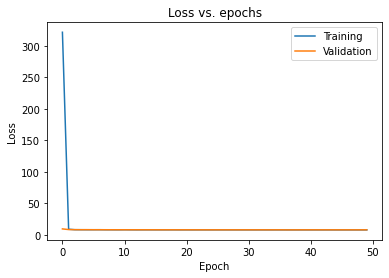

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

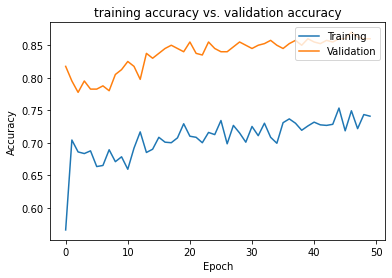

In [ ]:
plt.plot(history.history['binary_accuracy'])
plt.plot(history.history['val_binary_accuracy'])
plt.title('training accuracy vs. validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

In [ ]:
get_val_accuracy(model_3c5, X_val, Y_val)

accuracy: 0.860


## Question 3 - d Dropout Regularization and L2 Regularization

In [ ]:
## d
# 3d-1
model_3d1 = Sequential([
                    Conv2D(filters=16, kernel_size=(3,3), strides=(1,1), padding='valid', activation = 'relu', input_shape=(64,64,3)), 
                    Flatten(),
                    Dense(units=64, activation='relu', name='dense_1', kernel_initializer='truncated_normal', bias_initializer='zeros',
                          kernel_regularizer=tf.keras.regularizers.l2(0.01)),
                    Dropout(0.5), #dropout rate
                    Dense(1, activation = 'sigmoid')
])

initializer = tf.keras.initializers.TruncatedNormal(mean=0., stddev=1.)
layer = tf.keras.layers.Dense(3, kernel_initializer=initializer)

model_3d1.compile(
    optimizer = tf.keras.optimizers.Adagrad(learning_rate=0.003), # the default values.
    loss = tf.keras.losses.BinaryCrossentropy(from_logits=True),          # use sigmoid activation, if in the final hidden layer, we do not specify an activation function or define a linear one.
    metrics = [tf.keras.metrics.BinaryAccuracy()]            # default is 0.5 (the threshold for predictions to be classed as positive).
)

history = model_3d1.fit(temp_x,temp_y,epochs=50,batch_size=256,verbose=2,validation_split=0.25)


Epoch 1/50


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


5/5 - 4s - loss: 2667.3411 - binary_accuracy: 0.5142 - val_loss: 126.9822 - val_binary_accuracy: 0.5100 - 4s/epoch - 735ms/step
Epoch 2/50
5/5 - 2s - loss: 87.4936 - binary_accuracy: 0.6008 - val_loss: 77.9765 - val_binary_accuracy: 0.6075 - 2s/epoch - 459ms/step
Epoch 3/50
5/5 - 2s - loss: 77.2991 - binary_accuracy: 0.6050 - val_loss: 77.3031 - val_binary_accuracy: 0.6150 - 2s/epoch - 449ms/step
Epoch 4/50
5/5 - 3s - loss: 76.7366 - binary_accuracy: 0.5925 - val_loss: 76.9919 - val_binary_accuracy: 0.5925 - 3s/epoch - 678ms/step
Epoch 5/50
5/5 - 3s - loss: 76.6988 - binary_accuracy: 0.6125 - val_loss: 76.7322 - val_binary_accuracy: 0.6100 - 3s/epoch - 676ms/step
Epoch 6/50
5/5 - 2s - loss: 76.6563 - binary_accuracy: 0.5975 - val_loss: 76.5537 - val_binary_accuracy: 0.6125 - 2s/epoch - 457ms/step
Epoch 7/50
5/5 - 2s - loss: 76.4177 - binary_accuracy: 0.5983 - val_loss: 76.4387 - val_binary_accuracy: 0.6100 - 2s/epoch - 455ms/step
Epoch 8/50
5/5 - 2s - loss: 76.2944 - binary_accuracy: 0

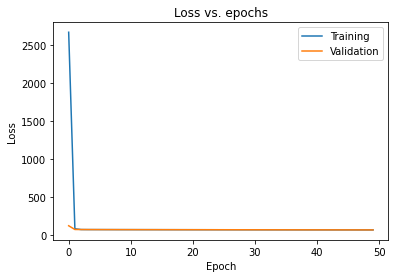

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

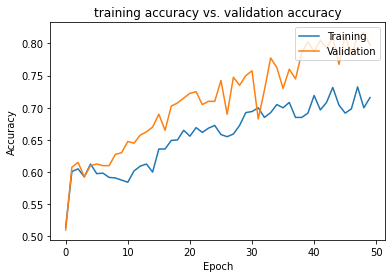

In [ ]:
plt.plot(history.history['binary_accuracy'])
plt.plot(history.history['val_binary_accuracy'])
plt.title('training accuracy vs. validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

In [ ]:
get_val_accuracy(model_3d1, X_val, Y_val)

accuracy: 0.798


In [ ]:
# 3d-2
model_3d2 = Sequential([
                    Conv2D(filters=16, kernel_size=(3,3), strides=(1,1), padding='valid', activation = 'relu', input_shape=(64,64,3)), 
                    Flatten(),
                    Dense(units=64, activation='relu', name='dense_1', kernel_initializer='truncated_normal', bias_initializer='zeros',
                          kernel_regularizer=tf.keras.regularizers.l2(0.001)),
                    Dropout(0.5), #dropout rate
                    Dense(1, activation = 'sigmoid')
])

initializer = tf.keras.initializers.TruncatedNormal(mean=0., stddev=1.)
layer = tf.keras.layers.Dense(3, kernel_initializer=initializer)

model_3d2.compile(
    optimizer = tf.keras.optimizers.Adagrad(learning_rate=0.003), # the default values.
    loss = tf.keras.losses.BinaryCrossentropy(from_logits=True),          # use sigmoid activation, if in the final hidden layer, we do not specify an activation function or define a linear one.
    metrics = [tf.keras.metrics.BinaryAccuracy()]            # default is 0.5 (the threshold for predictions to be classed as positive).
)

history = model_3d2.fit(temp_x,temp_y,epochs=50,batch_size=256,verbose=2,validation_split=0.25)


Epoch 1/50


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


5/5 - 9s - loss: 841.6653 - binary_accuracy: 0.4933 - val_loss: 40.2149 - val_binary_accuracy: 0.5525 - 9s/epoch - 2s/step
Epoch 2/50
5/5 - 5s - loss: 27.0971 - binary_accuracy: 0.5558 - val_loss: 9.0578 - val_binary_accuracy: 0.5000 - 5s/epoch - 1s/step
Epoch 3/50
5/5 - 4s - loss: 8.5422 - binary_accuracy: 0.6333 - val_loss: 8.5149 - val_binary_accuracy: 0.7575 - 4s/epoch - 856ms/step
Epoch 4/50
5/5 - 4s - loss: 8.2865 - binary_accuracy: 0.7183 - val_loss: 8.3741 - val_binary_accuracy: 0.7875 - 4s/epoch - 856ms/step
Epoch 5/50
5/5 - 2s - loss: 8.2985 - binary_accuracy: 0.7300 - val_loss: 8.3145 - val_binary_accuracy: 0.7900 - 2s/epoch - 453ms/step
Epoch 6/50
5/5 - 2s - loss: 8.2587 - binary_accuracy: 0.6933 - val_loss: 8.2193 - val_binary_accuracy: 0.7850 - 2s/epoch - 458ms/step
Epoch 7/50
5/5 - 2s - loss: 8.2230 - binary_accuracy: 0.7133 - val_loss: 8.2034 - val_binary_accuracy: 0.7925 - 2s/epoch - 461ms/step
Epoch 8/50
5/5 - 2s - loss: 8.1938 - binary_accuracy: 0.7242 - val_loss: 8.

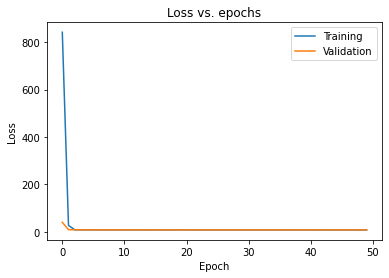

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

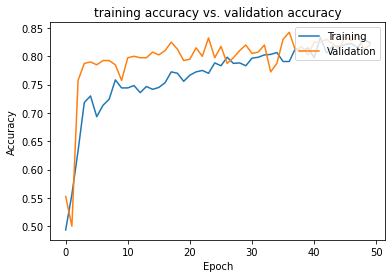

In [ ]:
plt.plot(history.history['binary_accuracy'])
plt.plot(history.history['val_binary_accuracy'])
plt.title('training accuracy vs. validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

In [ ]:
get_val_accuracy(model_3d2, X_val, Y_val)

accuracy: 0.820


In [ ]:
# 3d-3
model_3d3 = Sequential([
                    Conv2D(filters=16, kernel_size=(3,3), strides=(1,1), padding='valid', activation = 'relu', input_shape=(64,64,3)), 
                    Flatten(),
                    Dense(units=64, activation='relu', name='dense_1', kernel_initializer='truncated_normal', bias_initializer='zeros',
                          kernel_regularizer=tf.keras.regularizers.l2(0.0075)),
                    Dropout(0.7), #dropout rate
                    Dense(1, activation = 'sigmoid')
])

initializer = tf.keras.initializers.TruncatedNormal(mean=0., stddev=1.)
layer = tf.keras.layers.Dense(3, kernel_initializer=initializer)

model_3d3.compile(
    optimizer = tf.keras.optimizers.Adagrad(learning_rate=0.003), # the default values.
    loss = tf.keras.losses.BinaryCrossentropy(from_logits=True),          # use sigmoid activation, if in the final hidden layer, we do not specify an activation function or define a linear one.
    metrics = [tf.keras.metrics.BinaryAccuracy()]            # default is 0.5 (the threshold for predictions to be classed as positive).
)

history = model_3d3.fit(temp_x,temp_y,epochs=50,batch_size=256,verbose=2,validation_split=0.25)


Epoch 1/50


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


5/5 - 3s - loss: 1098.7572 - binary_accuracy: 0.5417 - val_loss: 108.4014 - val_binary_accuracy: 0.6675 - 3s/epoch - 595ms/step
Epoch 2/50
5/5 - 2s - loss: 88.6111 - binary_accuracy: 0.5550 - val_loss: 58.4592 - val_binary_accuracy: 0.5950 - 2s/epoch - 454ms/step
Epoch 3/50
5/5 - 2s - loss: 57.9956 - binary_accuracy: 0.5342 - val_loss: 58.3414 - val_binary_accuracy: 0.5950 - 2s/epoch - 450ms/step
Epoch 4/50
5/5 - 2s - loss: 57.8783 - binary_accuracy: 0.5092 - val_loss: 58.2143 - val_binary_accuracy: 0.5925 - 2s/epoch - 448ms/step
Epoch 5/50
5/5 - 4s - loss: 57.8163 - binary_accuracy: 0.5242 - val_loss: 58.0021 - val_binary_accuracy: 0.5875 - 4s/epoch - 868ms/step
Epoch 6/50
5/5 - 4s - loss: 57.7136 - binary_accuracy: 0.5242 - val_loss: 57.7623 - val_binary_accuracy: 0.6025 - 4s/epoch - 898ms/step
Epoch 7/50
5/5 - 5s - loss: 57.5747 - binary_accuracy: 0.5208 - val_loss: 57.6963 - val_binary_accuracy: 0.6025 - 5s/epoch - 957ms/step
Epoch 8/50
5/5 - 2s - loss: 57.5061 - binary_accuracy: 0

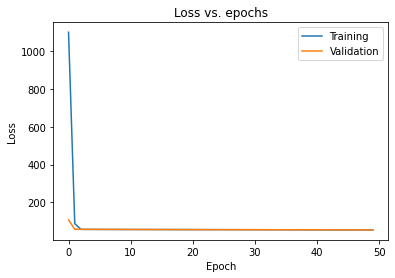

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

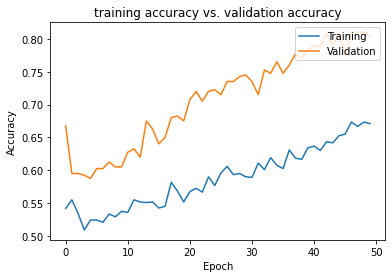

In [ ]:
plt.plot(history.history['binary_accuracy'])
plt.plot(history.history['val_binary_accuracy'])
plt.title('training accuracy vs. validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

In [ ]:
get_val_accuracy(model_3d3, X_val, Y_val)

accuracy: 0.805


In [ ]:
# 3d-4
model_3d4 = Sequential([
                    Conv2D(filters=16, kernel_size=(3,3), strides=(1,1), padding='valid', activation = 'relu', input_shape=(64,64,3)), 
                    Flatten(),
                    Dense(units=64, activation='relu', name='dense_1', kernel_initializer='truncated_normal', bias_initializer='zeros',
                          kernel_regularizer=tf.keras.regularizers.l2(0.0025)),
                    Dropout(0.4), #dropout rate
                    Dense(1, activation = 'sigmoid')
])

initializer = tf.keras.initializers.TruncatedNormal(mean=0., stddev=1.)
layer = tf.keras.layers.Dense(3, kernel_initializer=initializer)

model_3d4.compile(
    optimizer = tf.keras.optimizers.Adagrad(learning_rate=0.003), # the default values.
    loss = tf.keras.losses.BinaryCrossentropy(from_logits=True),          # use sigmoid activation, if in the final hidden layer, we do not specify an activation function or define a linear one.
    metrics = [tf.keras.metrics.BinaryAccuracy()]            # default is 0.5 (the threshold for predictions to be classed as positive).
)

history = model_3d4.fit(temp_x,temp_y,epochs=50,batch_size=256,verbose=2,validation_split=0.25)


Epoch 1/50


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


5/5 - 63s - loss: 491.4595 - binary_accuracy: 0.5108 - val_loss: 64.3738 - val_binary_accuracy: 0.7150 - 63s/epoch - 13s/step
Epoch 2/50
5/5 - 2s - loss: 54.6038 - binary_accuracy: 0.7417 - val_loss: 27.6957 - val_binary_accuracy: 0.8225 - 2s/epoch - 457ms/step
Epoch 3/50
5/5 - 2s - loss: 24.6167 - binary_accuracy: 0.8317 - val_loss: 21.3985 - val_binary_accuracy: 0.8175 - 2s/epoch - 454ms/step
Epoch 4/50
5/5 - 2s - loss: 20.6231 - binary_accuracy: 0.8133 - val_loss: 20.4166 - val_binary_accuracy: 0.7650 - 2s/epoch - 450ms/step
Epoch 5/50
5/5 - 2s - loss: 19.7832 - binary_accuracy: 0.7992 - val_loss: 20.2362 - val_binary_accuracy: 0.8300 - 2s/epoch - 452ms/step
Epoch 6/50
5/5 - 2s - loss: 19.6525 - binary_accuracy: 0.7892 - val_loss: 20.0487 - val_binary_accuracy: 0.8275 - 2s/epoch - 455ms/step
Epoch 7/50
5/5 - 2s - loss: 19.6827 - binary_accuracy: 0.7833 - val_loss: 19.9723 - val_binary_accuracy: 0.8175 - 2s/epoch - 449ms/step
Epoch 8/50
5/5 - 2s - loss: 19.5143 - binary_accuracy: 0.7

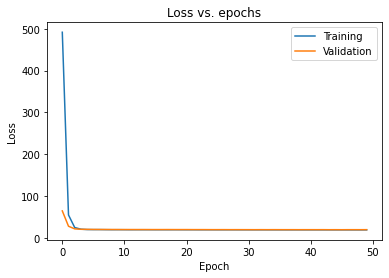

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

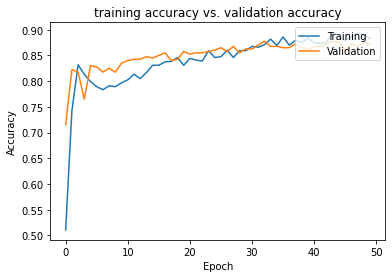

In [ ]:
plt.plot(history.history['binary_accuracy'])
plt.plot(history.history['val_binary_accuracy'])
plt.title('training accuracy vs. validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

In [ ]:
get_val_accuracy(model_3d4, X_val, Y_val)

accuracy: 0.873


In [ ]:
# 3d-5
model_3d5 = Sequential([
                    Conv2D(filters=16, kernel_size=(3,3), strides=(1,1), padding='valid', activation = 'relu', input_shape=(64,64,3)), 
                    Flatten(),
                    Dense(units=64, activation='relu', name='dense_1', kernel_initializer='truncated_normal', bias_initializer='zeros',
                          kernel_regularizer=tf.keras.regularizers.l2(0.0015)),
                    Dropout(0.3), #dropout rate
                    Dense(1, activation = 'sigmoid')
])

initializer = tf.keras.initializers.TruncatedNormal(mean=0., stddev=1.)
layer = tf.keras.layers.Dense(3, kernel_initializer=initializer)

model_3d5.compile(
    optimizer = tf.keras.optimizers.Adagrad(learning_rate=0.003), # the default values.
    loss = tf.keras.losses.BinaryCrossentropy(from_logits=True),          # use sigmoid activation, if in the final hidden layer, we do not specify an activation function or define a linear one.
    metrics = [tf.keras.metrics.BinaryAccuracy()]            # default is 0.5 (the threshold for predictions to be classed as positive).
)

history = model_3d5.fit(temp_x,temp_y,epochs=50,batch_size=256,verbose=2,validation_split=0.25)


Epoch 1/50


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


5/5 - 3s - loss: 1171.6393 - binary_accuracy: 0.4867 - val_loss: 591.4543 - val_binary_accuracy: 0.5000 - 3s/epoch - 600ms/step
Epoch 2/50
5/5 - 2s - loss: 226.1937 - binary_accuracy: 0.6433 - val_loss: 40.5435 - val_binary_accuracy: 0.8125 - 2s/epoch - 458ms/step
Epoch 3/50
5/5 - 2s - loss: 89.3310 - binary_accuracy: 0.7200 - val_loss: 234.5138 - val_binary_accuracy: 0.5225 - 2s/epoch - 452ms/step
Epoch 4/50
5/5 - 2s - loss: 78.4470 - binary_accuracy: 0.7783 - val_loss: 25.4393 - val_binary_accuracy: 0.8700 - 2s/epoch - 452ms/step
Epoch 5/50
5/5 - 2s - loss: 26.5256 - binary_accuracy: 0.8667 - val_loss: 23.8074 - val_binary_accuracy: 0.8625 - 2s/epoch - 451ms/step
Epoch 6/50
5/5 - 2s - loss: 21.0894 - binary_accuracy: 0.8883 - val_loss: 21.4278 - val_binary_accuracy: 0.8700 - 2s/epoch - 453ms/step
Epoch 7/50
5/5 - 2s - loss: 20.0785 - binary_accuracy: 0.8967 - val_loss: 25.6601 - val_binary_accuracy: 0.8125 - 2s/epoch - 458ms/step
Epoch 8/50
5/5 - 2s - loss: 17.8926 - binary_accuracy:

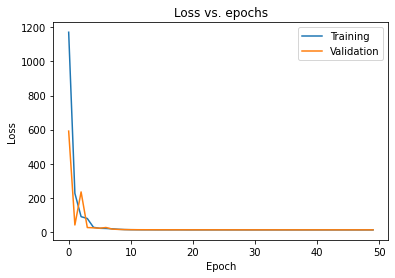

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

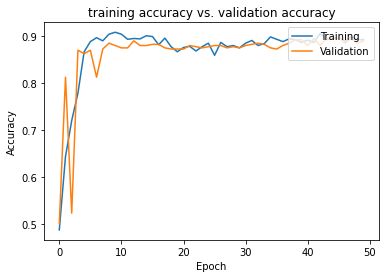

In [ ]:
plt.plot(history.history['binary_accuracy'])
plt.plot(history.history['val_binary_accuracy'])
plt.title('training accuracy vs. validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

In [ ]:
get_val_accuracy(model_3d5, X_val, Y_val)

accuracy: 0.890


 ## Question 3 - e Batch-normalization

In [ ]:
# 3e-1
model_3e1 = Sequential([
                    Conv2D(filters=16, kernel_size=(3,3), strides=(1,1), padding='valid', activation = 'relu', input_shape=(64,64,3)), 
                    Flatten(),
                    Dense(units=64, activation='relu', name='dense_1', kernel_initializer='truncated_normal', bias_initializer='zeros'),
                    BatchNormalization(),
                    Dense(1, activation = 'sigmoid')
])

initializer = tf.keras.initializers.TruncatedNormal(mean=0., stddev=1.)
layer = tf.keras.layers.Dense(3, kernel_initializer=initializer)

model_3e1.compile(
    optimizer = tf.keras.optimizers.Adagrad(learning_rate=0.003), # the default values.
    loss = tf.keras.losses.BinaryCrossentropy(from_logits=True),          # use sigmoid activation, if in the final hidden layer, we do not specify an activation function or define a linear one.
    metrics = [tf.keras.metrics.BinaryAccuracy()]            # default is 0.5 (the threshold for predictions to be classed as positive).
)

history = model_3e1.fit(temp_x,temp_y,epochs=50,batch_size=256,verbose=2,validation_split=0.25)


Epoch 1/50


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


5/5 - 4s - loss: 0.6263 - binary_accuracy: 0.6908 - val_loss: 1.0368 - val_binary_accuracy: 0.7825 - 4s/epoch - 737ms/step
Epoch 2/50
5/5 - 2s - loss: 0.4651 - binary_accuracy: 0.8008 - val_loss: 0.6477 - val_binary_accuracy: 0.8125 - 2s/epoch - 459ms/step
Epoch 3/50
5/5 - 2s - loss: 0.3996 - binary_accuracy: 0.8367 - val_loss: 0.5187 - val_binary_accuracy: 0.8200 - 2s/epoch - 447ms/step
Epoch 4/50
5/5 - 2s - loss: 0.3546 - binary_accuracy: 0.8667 - val_loss: 0.4245 - val_binary_accuracy: 0.8275 - 2s/epoch - 437ms/step
Epoch 5/50
5/5 - 2s - loss: 0.3270 - binary_accuracy: 0.8825 - val_loss: 0.3531 - val_binary_accuracy: 0.8425 - 2s/epoch - 435ms/step
Epoch 6/50
5/5 - 2s - loss: 0.3041 - binary_accuracy: 0.8958 - val_loss: 0.3352 - val_binary_accuracy: 0.8525 - 2s/epoch - 435ms/step
Epoch 7/50
5/5 - 2s - loss: 0.2892 - binary_accuracy: 0.9017 - val_loss: 0.3115 - val_binary_accuracy: 0.8575 - 2s/epoch - 441ms/step
Epoch 8/50
5/5 - 2s - loss: 0.2716 - binary_accuracy: 0.9092 - val_loss: 

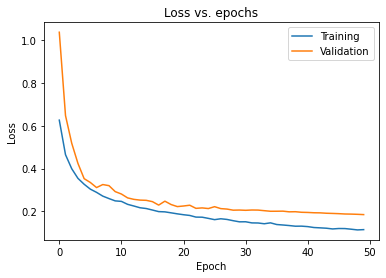

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

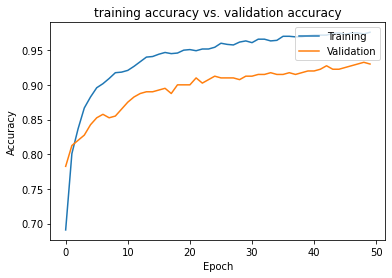

In [ ]:
plt.plot(history.history['binary_accuracy'])
plt.plot(history.history['val_binary_accuracy'])
plt.title('training accuracy vs. validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

In [ ]:
get_val_accuracy(model_3e1, X_val, Y_val)

accuracy: 0.930


In [ ]:
# 3e-2
model_3e2 = Sequential([
                    Conv2D(filters=16, kernel_size=(3,3), strides=(1,1), padding='valid', activation = 'relu', input_shape=(64,64,3)), 
                    Flatten(),
                    Dense(units=64, activation='relu', name='dense_1', kernel_initializer='truncated_normal', bias_initializer='zeros'),
                    BatchNormalization(),
                    Dense(1, activation = 'sigmoid')
])

model_3e2.add(tf.keras.layers.BatchNormalization(
    momentum=0.95, # default is 0.99
    epsilon=0.005, #default is 0.001
    axis = -1, #default is -1
    beta_initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.05), # default is beta_initializer='zeros'
    gamma_initializer=tf.keras.initializers.Constant(value=0.9) # default is gamma_initializer='ones'
))

model_3e2.add(Dense(1))


initializer = tf.keras.initializers.TruncatedNormal(mean=0., stddev=1.)
layer = tf.keras.layers.Dense(3, kernel_initializer=initializer)

model_3e2.compile(
    optimizer = tf.keras.optimizers.Adagrad(learning_rate=0.003), # the default values.
    loss = tf.keras.losses.BinaryCrossentropy(from_logits=True),          # use sigmoid activation, if in the final hidden layer, we do not specify an activation function or define a linear one.
    metrics = [tf.keras.metrics.BinaryAccuracy()]            # default is 0.5 (the threshold for predictions to be classed as positive).
)

history = model_3e2.fit(temp_x,temp_y,epochs=50,batch_size=256,verbose=2,validation_split=0.25)


Epoch 1/50
5/5 - 3s - loss: 0.7521 - binary_accuracy: 0.5475 - val_loss: 0.6374 - val_binary_accuracy: 0.6750 - 3s/epoch - 640ms/step
Epoch 2/50
5/5 - 2s - loss: 0.6057 - binary_accuracy: 0.6800 - val_loss: 0.6145 - val_binary_accuracy: 0.6975 - 2s/epoch - 447ms/step
Epoch 3/50
5/5 - 2s - loss: 0.5497 - binary_accuracy: 0.7317 - val_loss: 0.5953 - val_binary_accuracy: 0.7150 - 2s/epoch - 440ms/step
Epoch 4/50
5/5 - 3s - loss: 0.5157 - binary_accuracy: 0.7658 - val_loss: 0.5749 - val_binary_accuracy: 0.7275 - 3s/epoch - 528ms/step
Epoch 5/50
5/5 - 2s - loss: 0.4976 - binary_accuracy: 0.7842 - val_loss: 0.5551 - val_binary_accuracy: 0.7425 - 2s/epoch - 436ms/step
Epoch 6/50
5/5 - 2s - loss: 0.4850 - binary_accuracy: 0.7992 - val_loss: 0.5352 - val_binary_accuracy: 0.7800 - 2s/epoch - 434ms/step
Epoch 7/50
5/5 - 2s - loss: 0.4757 - binary_accuracy: 0.8042 - val_loss: 0.5193 - val_binary_accuracy: 0.7975 - 2s/epoch - 439ms/step
Epoch 8/50
5/5 - 2s - loss: 0.4664 - binary_accuracy: 0.8158 -

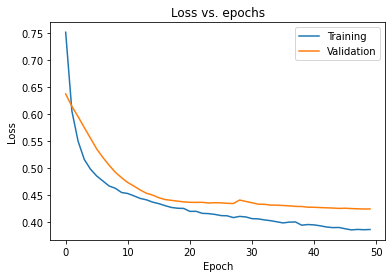

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

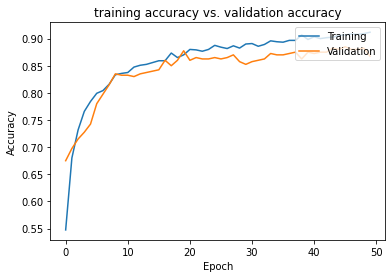

In [ ]:
plt.plot(history.history['binary_accuracy'])
plt.plot(history.history['val_binary_accuracy'])
plt.title('training accuracy vs. validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

In [ ]:
get_val_accuracy(model_3e2, X_val, Y_val)

accuracy: 0.868


In [ ]:
# 3e-3
model_3e3 = Sequential([
                    Conv2D(filters=16, kernel_size=(3,3), strides=(1,1), padding='valid', activation = 'relu', input_shape=(64,64,3)), 
                    Flatten(),
                    Dense(units=64, activation='relu', name='dense_1', kernel_initializer='truncated_normal', bias_initializer='zeros'),
                    BatchNormalization(),
                    Dense(1, activation = 'sigmoid')
])

model_3e3.add(tf.keras.layers.BatchNormalization(
    momentum=0.90, # default is 0.99
    epsilon=0.003, #default is 0.001
    axis = -1, #default is -1
    beta_initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.05), # default is beta_initializer='zeros'
    gamma_initializer=tf.keras.initializers.Constant(value=0.9) # default is gamma_initializer='ones'
))

model_3e3.add(Dense(1))


initializer = tf.keras.initializers.TruncatedNormal(mean=0., stddev=1.)
layer = tf.keras.layers.Dense(3, kernel_initializer=initializer)

model_3e3.compile(
    optimizer = tf.keras.optimizers.Adagrad(learning_rate=0.003), # the default values.
    loss = tf.keras.losses.BinaryCrossentropy(from_logits=True),          # use sigmoid activation, if in the final hidden layer, we do not specify an activation function or define a linear one.
    metrics = [tf.keras.metrics.BinaryAccuracy()]            # default is 0.5 (the threshold for predictions to be classed as positive).
)

history = model_3e3.fit(temp_x,temp_y,epochs=50,batch_size=256,verbose=2,validation_split=0.25)


Epoch 1/50
5/5 - 5s - loss: 0.6299 - binary_accuracy: 0.6733 - val_loss: 0.6717 - val_binary_accuracy: 0.5000 - 5s/epoch - 999ms/step
Epoch 2/50
5/5 - 4s - loss: 0.5305 - binary_accuracy: 0.7358 - val_loss: 0.5895 - val_binary_accuracy: 0.5800 - 4s/epoch - 825ms/step
Epoch 3/50
5/5 - 4s - loss: 0.4818 - binary_accuracy: 0.7808 - val_loss: 0.5126 - val_binary_accuracy: 0.7775 - 4s/epoch - 863ms/step
Epoch 4/50
5/5 - 3s - loss: 0.4536 - binary_accuracy: 0.8042 - val_loss: 0.4776 - val_binary_accuracy: 0.8025 - 3s/epoch - 673ms/step
Epoch 5/50
5/5 - 2s - loss: 0.4381 - binary_accuracy: 0.8150 - val_loss: 0.4543 - val_binary_accuracy: 0.8050 - 2s/epoch - 442ms/step
Epoch 6/50
5/5 - 2s - loss: 0.4258 - binary_accuracy: 0.8258 - val_loss: 0.4370 - val_binary_accuracy: 0.8100 - 2s/epoch - 432ms/step
Epoch 7/50
5/5 - 2s - loss: 0.4157 - binary_accuracy: 0.8325 - val_loss: 0.4295 - val_binary_accuracy: 0.8100 - 2s/epoch - 435ms/step
Epoch 8/50
5/5 - 2s - loss: 0.4071 - binary_accuracy: 0.8358 -

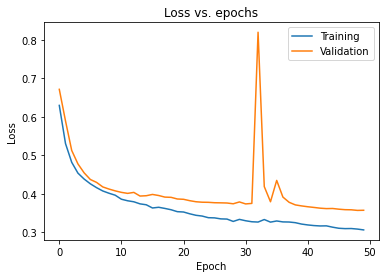

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

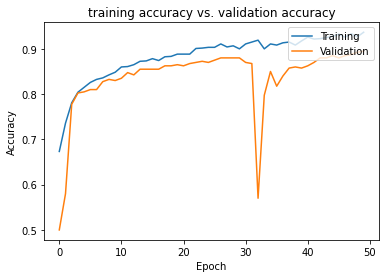

In [ ]:
plt.plot(history.history['binary_accuracy'])
plt.plot(history.history['val_binary_accuracy'])
plt.title('training accuracy vs. validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

In [ ]:
get_val_accuracy(model_3e3, X_val, Y_val)

accuracy: 0.895


In [ ]:
# 3e-4
model_3e4 = Sequential([
                    Conv2D(filters=16, kernel_size=(3,3), strides=(1,1), padding='valid', activation = 'relu', input_shape=(64,64,3)), 
                    Flatten(),
                    Dense(units=64, activation='relu', name='dense_1', kernel_initializer='truncated_normal', bias_initializer='zeros'),
                    BatchNormalization(),
                    Dense(1, activation = 'sigmoid')
])

model_3e4.add(tf.keras.layers.BatchNormalization(
    momentum=0.97, # default is 0.99
    epsilon=0.008, #default is 0.001
    axis = -1, #default is -1
    beta_initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.05), # default is beta_initializer='zeros'
    gamma_initializer=tf.keras.initializers.Constant(value=0.9) # default is gamma_initializer='ones'
))

model_3e4.add(Dense(1))


initializer = tf.keras.initializers.TruncatedNormal(mean=0., stddev=1.)
layer = tf.keras.layers.Dense(3, kernel_initializer=initializer)

model_3e4.compile(
    optimizer = tf.keras.optimizers.Adagrad(learning_rate=0.003), # the default values.
    loss = tf.keras.losses.BinaryCrossentropy(from_logits=True),          # use sigmoid activation, if in the final hidden layer, we do not specify an activation function or define a linear one.
    metrics = [tf.keras.metrics.BinaryAccuracy()]            # default is 0.5 (the threshold for predictions to be classed as positive).
)

history = model_3e4.fit(temp_x,temp_y,epochs=50,batch_size=256,verbose=2,validation_split=0.25)


Epoch 1/50
5/5 - 3s - loss: 0.6253 - binary_accuracy: 0.6633 - val_loss: 0.5821 - val_binary_accuracy: 0.5000 - 3s/epoch - 641ms/step
Epoch 2/50
5/5 - 2s - loss: 0.4814 - binary_accuracy: 0.7633 - val_loss: 0.5545 - val_binary_accuracy: 0.5000 - 2s/epoch - 436ms/step
Epoch 3/50
5/5 - 2s - loss: 0.4407 - binary_accuracy: 0.8017 - val_loss: 0.5409 - val_binary_accuracy: 0.5000 - 2s/epoch - 439ms/step
Epoch 4/50
5/5 - 2s - loss: 0.4144 - binary_accuracy: 0.8300 - val_loss: 0.5223 - val_binary_accuracy: 0.5000 - 2s/epoch - 433ms/step
Epoch 5/50
5/5 - 2s - loss: 0.4051 - binary_accuracy: 0.8400 - val_loss: 0.5121 - val_binary_accuracy: 0.7850 - 2s/epoch - 433ms/step
Epoch 6/50
5/5 - 2s - loss: 0.3892 - binary_accuracy: 0.8558 - val_loss: 0.4998 - val_binary_accuracy: 0.8100 - 2s/epoch - 434ms/step
Epoch 7/50
5/5 - 2s - loss: 0.3770 - binary_accuracy: 0.8667 - val_loss: 0.4893 - val_binary_accuracy: 0.8250 - 2s/epoch - 432ms/step
Epoch 8/50
5/5 - 2s - loss: 0.3737 - binary_accuracy: 0.8717 -

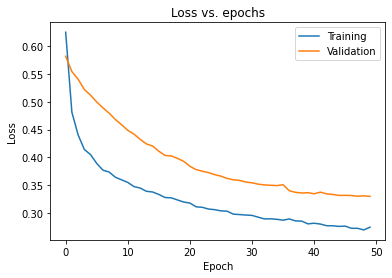

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

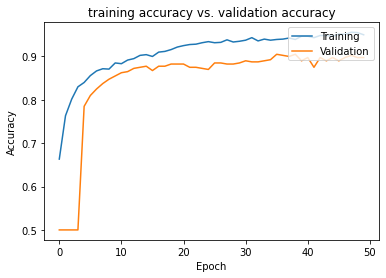

In [ ]:
plt.plot(history.history['binary_accuracy'])
plt.plot(history.history['val_binary_accuracy'])
plt.title('training accuracy vs. validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

In [ ]:
get_val_accuracy(model_3e4, X_val, Y_val)

accuracy: 0.897


In [ ]:
# 3e-5
model_3e5 = Sequential([
                    Conv2D(filters=16, kernel_size=(3,3), strides=(1,1), padding='valid', activation = 'relu', input_shape=(64,64,3)), 
                    Flatten(),
                    Dense(units=64, activation='relu', name='dense_1', kernel_initializer='truncated_normal', bias_initializer='zeros'),
                    BatchNormalization(),
                    Dense(1, activation = 'sigmoid')
])

model_3e5.add(tf.keras.layers.BatchNormalization(
    momentum=0.90, # default is 0.99
    epsilon=0.006, #default is 0.001
    axis = -1, #default is -1
    beta_initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.05), # default is beta_initializer='zeros'
    gamma_initializer=tf.keras.initializers.Constant(value=0.9) # default is gamma_initializer='ones'
))

model_3e5.add(Dense(1))


initializer = tf.keras.initializers.TruncatedNormal(mean=0., stddev=1.)
layer = tf.keras.layers.Dense(3, kernel_initializer=initializer)

model_3e5.compile(
    optimizer = tf.keras.optimizers.Adagrad(learning_rate=0.003), # the default values.
    loss = tf.keras.losses.BinaryCrossentropy(from_logits=True),          # use sigmoid activation, if in the final hidden layer, we do not specify an activation function or define a linear one.
    metrics = [tf.keras.metrics.BinaryAccuracy()]            # default is 0.5 (the threshold for predictions to be classed as positive).
)

history = model_3e5.fit(temp_x,temp_y,epochs=50,batch_size=256,verbose=2,validation_split=0.25)


Epoch 1/50
5/5 - 3s - loss: 0.6034 - binary_accuracy: 0.6700 - val_loss: 0.5961 - val_binary_accuracy: 0.5000 - 3s/epoch - 663ms/step
Epoch 2/50
5/5 - 2s - loss: 0.4505 - binary_accuracy: 0.7892 - val_loss: 0.5323 - val_binary_accuracy: 0.7600 - 2s/epoch - 442ms/step
Epoch 3/50
5/5 - 2s - loss: 0.4117 - binary_accuracy: 0.8192 - val_loss: 0.4805 - val_binary_accuracy: 0.8050 - 2s/epoch - 441ms/step
Epoch 4/50
5/5 - 2s - loss: 0.3935 - binary_accuracy: 0.8408 - val_loss: 0.4459 - val_binary_accuracy: 0.8125 - 2s/epoch - 437ms/step
Epoch 5/50
5/5 - 2s - loss: 0.3784 - binary_accuracy: 0.8508 - val_loss: 0.4237 - val_binary_accuracy: 0.8275 - 2s/epoch - 437ms/step
Epoch 6/50
5/5 - 2s - loss: 0.3628 - binary_accuracy: 0.8642 - val_loss: 0.4041 - val_binary_accuracy: 0.8350 - 2s/epoch - 442ms/step
Epoch 7/50
5/5 - 2s - loss: 0.3562 - binary_accuracy: 0.8717 - val_loss: 0.3918 - val_binary_accuracy: 0.8375 - 2s/epoch - 435ms/step
Epoch 8/50
5/5 - 2s - loss: 0.3507 - binary_accuracy: 0.8750 -

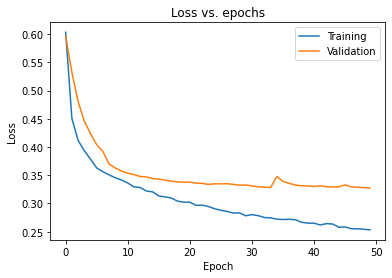

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

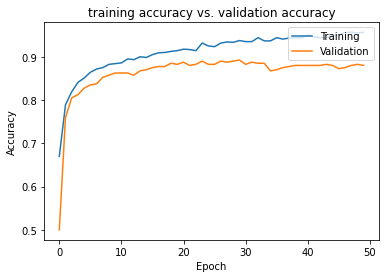

In [ ]:
plt.plot(history.history['binary_accuracy'])
plt.plot(history.history['val_binary_accuracy'])
plt.title('training accuracy vs. validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

In [ ]:
get_val_accuracy(model_3e5, X_val, Y_val)

accuracy: 0.880


## Question 3 - f Batch- normalization and Dropout regularization

In [ ]:
model_4f1 = Sequential([
                    Conv2D(filters=16, kernel_size=(3,3), strides=(1,1), padding='valid', activation = 'relu', input_shape=(64,64,3)), 
                    Flatten(),
                    Dense(units=64, activation='relu', name='dense_1', kernel_initializer='truncated_normal', bias_initializer='zeros'),
                    BatchNormalization(),
                    Dropout(0.5),
                    Dense(1, activation = 'sigmoid')
])

initializer = tf.keras.initializers.TruncatedNormal(mean=0., stddev=1.)
layer = tf.keras.layers.Dense(3, kernel_initializer=initializer)

model_4f1.compile(
    optimizer = tf.keras.optimizers.Adagrad(learning_rate=0.003), # the default values.
    loss = tf.keras.losses.BinaryCrossentropy(from_logits=True),          # use sigmoid activation, if in the final hidden layer, we do not specify an activation function or define a linear one.
    metrics = [tf.keras.metrics.BinaryAccuracy()]            # default is 0.5 (the threshold for predictions to be classed as positive).
)

history = model_4f1.fit(temp_x,temp_y,epochs=50,batch_size=256,verbose=2,validation_split=0.25)


Epoch 1/50


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


5/5 - 3s - loss: 0.9189 - binary_accuracy: 0.5900 - val_loss: 2.1164 - val_binary_accuracy: 0.6700 - 3s/epoch - 616ms/step
Epoch 2/50
5/5 - 2s - loss: 0.7104 - binary_accuracy: 0.7033 - val_loss: 0.9670 - val_binary_accuracy: 0.7875 - 2s/epoch - 438ms/step
Epoch 3/50
5/5 - 2s - loss: 0.6024 - binary_accuracy: 0.7383 - val_loss: 0.7155 - val_binary_accuracy: 0.8175 - 2s/epoch - 435ms/step
Epoch 4/50
5/5 - 2s - loss: 0.5484 - binary_accuracy: 0.7858 - val_loss: 0.5573 - val_binary_accuracy: 0.8475 - 2s/epoch - 445ms/step
Epoch 5/50
5/5 - 2s - loss: 0.4693 - binary_accuracy: 0.8092 - val_loss: 0.5094 - val_binary_accuracy: 0.8550 - 2s/epoch - 437ms/step
Epoch 6/50
5/5 - 2s - loss: 0.4413 - binary_accuracy: 0.8200 - val_loss: 0.4520 - val_binary_accuracy: 0.8725 - 2s/epoch - 435ms/step
Epoch 7/50
5/5 - 2s - loss: 0.4250 - binary_accuracy: 0.8142 - val_loss: 0.3961 - val_binary_accuracy: 0.8725 - 2s/epoch - 434ms/step
Epoch 8/50
5/5 - 2s - loss: 0.3895 - binary_accuracy: 0.8475 - val_loss: 

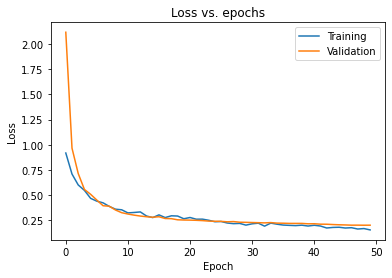

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

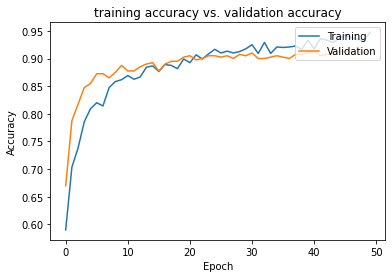

In [ ]:
plt.plot(history.history['binary_accuracy'])
plt.plot(history.history['val_binary_accuracy'])
plt.title('training accuracy vs. validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

In [ ]:
get_val_accuracy(model_4f1, X_val, Y_val)

accuracy: 0.915


In [ ]:
model_4f2 = Sequential([
                    Conv2D(filters=16, kernel_size=(3,3), strides=(1,1), padding='valid', activation = 'relu', input_shape=(64,64,3)), 
                    Flatten(),
                    Dense(units=64, activation='relu', name='dense_1', kernel_initializer='truncated_normal', bias_initializer='zeros'),
                    BatchNormalization(),
                    Dropout(0.3),
                    Dense(1, activation = 'sigmoid')
])


initializer = tf.keras.initializers.TruncatedNormal(mean=0., stddev=1.)
layer = tf.keras.layers.Dense(3, kernel_initializer=initializer)

model_4f2.compile(
    optimizer = tf.keras.optimizers.Adagrad(learning_rate=0.003), # the default values.
    loss = tf.keras.losses.BinaryCrossentropy(from_logits=True),          # use sigmoid activation, if in the final hidden layer, we do not specify an activation function or define a linear one.
    metrics = [tf.keras.metrics.BinaryAccuracy()]            # default is 0.5 (the threshold for predictions to be classed as positive).
)

history = model_4f2.fit(temp_x,temp_y,epochs=50,batch_size=256,verbose=2,validation_split=0.25)


Epoch 1/50


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


5/5 - 3s - loss: 0.9171 - binary_accuracy: 0.5475 - val_loss: 3.0793 - val_binary_accuracy: 0.5775 - 3s/epoch - 600ms/step
Epoch 2/50
5/5 - 2s - loss: 0.6891 - binary_accuracy: 0.6917 - val_loss: 1.5416 - val_binary_accuracy: 0.6550 - 2s/epoch - 444ms/step
Epoch 3/50
5/5 - 2s - loss: 0.5966 - binary_accuracy: 0.7367 - val_loss: 0.8909 - val_binary_accuracy: 0.7125 - 2s/epoch - 436ms/step
Epoch 4/50
5/5 - 2s - loss: 0.5329 - binary_accuracy: 0.7733 - val_loss: 0.6852 - val_binary_accuracy: 0.7675 - 2s/epoch - 435ms/step
Epoch 5/50
5/5 - 2s - loss: 0.4822 - binary_accuracy: 0.8158 - val_loss: 0.4647 - val_binary_accuracy: 0.8175 - 2s/epoch - 437ms/step
Epoch 6/50
5/5 - 2s - loss: 0.4401 - binary_accuracy: 0.8308 - val_loss: 0.4403 - val_binary_accuracy: 0.8325 - 2s/epoch - 436ms/step
Epoch 7/50
5/5 - 2s - loss: 0.4271 - binary_accuracy: 0.8417 - val_loss: 0.4176 - val_binary_accuracy: 0.8375 - 2s/epoch - 445ms/step
Epoch 8/50
5/5 - 2s - loss: 0.4111 - binary_accuracy: 0.8408 - val_loss: 

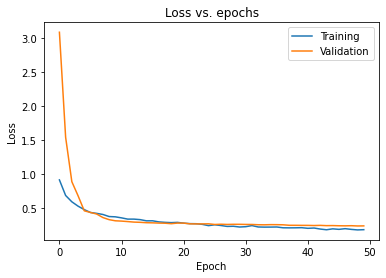

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

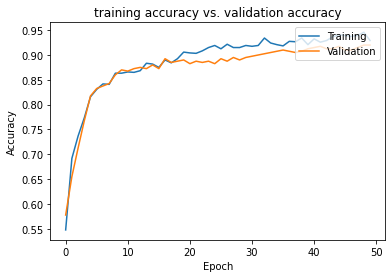

In [ ]:
plt.plot(history.history['binary_accuracy'])
plt.plot(history.history['val_binary_accuracy'])
plt.title('training accuracy vs. validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

In [ ]:
get_val_accuracy(model_4f2, X_val, Y_val)

accuracy: 0.920


In [ ]:
# f
model_4f3 = Sequential([
                    Conv2D(filters=16, kernel_size=(3,3), strides=(1,1), padding='valid', activation = 'relu', input_shape=(64,64,3)), 
                    Flatten(),
                    Dense(units=64, activation='relu', name='dense_1', kernel_initializer='truncated_normal', bias_initializer='zeros'),
                    BatchNormalization(),
                    Dropout(0.5),
                    Dense(1, activation = 'sigmoid')
])

model_4f3.add(tf.keras.layers.BatchNormalization(
    momentum=0.95, # default is 0.99
    epsilon=0.005, #default is 0.001
    axis = -1, #default is -1
    beta_initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.05), # default is beta_initializer='zeros'
    gamma_initializer=tf.keras.initializers.Constant(value=0.9) # default is gamma_initializer='ones'
))

model_4f3.add(Dense(1))


initializer = tf.keras.initializers.TruncatedNormal(mean=0., stddev=1.)
layer = tf.keras.layers.Dense(3, kernel_initializer=initializer)

model_4f3.compile(
    optimizer = tf.keras.optimizers.Adagrad(learning_rate=0.003), # the default values.
    loss = tf.keras.losses.BinaryCrossentropy(from_logits=True),          # use sigmoid activation, if in the final hidden layer, we do not specify an activation function or define a linear one.
    metrics = [tf.keras.metrics.BinaryAccuracy()]            # default is 0.5 (the threshold for predictions to be classed as positive).
)

history = model_4f3.fit(temp_x,temp_y,epochs=50,batch_size=256,verbose=2,validation_split=0.25)


Epoch 1/50
5/5 - 3s - loss: 0.6830 - binary_accuracy: 0.6350 - val_loss: 0.6747 - val_binary_accuracy: 0.5000 - 3s/epoch - 636ms/step
Epoch 2/50
5/5 - 2s - loss: 0.5982 - binary_accuracy: 0.6883 - val_loss: 0.6338 - val_binary_accuracy: 0.5000 - 2s/epoch - 434ms/step
Epoch 3/50
5/5 - 2s - loss: 0.5303 - binary_accuracy: 0.7308 - val_loss: 0.5800 - val_binary_accuracy: 0.5000 - 2s/epoch - 441ms/step
Epoch 4/50
5/5 - 2s - loss: 0.4971 - binary_accuracy: 0.7608 - val_loss: 0.5295 - val_binary_accuracy: 0.6750 - 2s/epoch - 431ms/step
Epoch 5/50
5/5 - 2s - loss: 0.4893 - binary_accuracy: 0.7675 - val_loss: 0.4910 - val_binary_accuracy: 0.7475 - 2s/epoch - 432ms/step
Epoch 6/50
5/5 - 2s - loss: 0.4573 - binary_accuracy: 0.7917 - val_loss: 0.4744 - val_binary_accuracy: 0.7775 - 2s/epoch - 428ms/step
Epoch 7/50
5/5 - 2s - loss: 0.4602 - binary_accuracy: 0.7783 - val_loss: 0.4555 - val_binary_accuracy: 0.7825 - 2s/epoch - 432ms/step
Epoch 8/50
5/5 - 2s - loss: 0.4445 - binary_accuracy: 0.7808 -

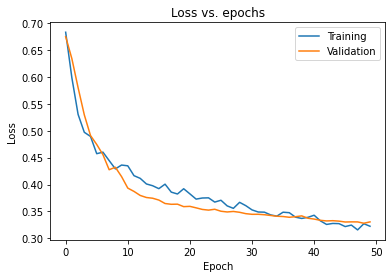

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

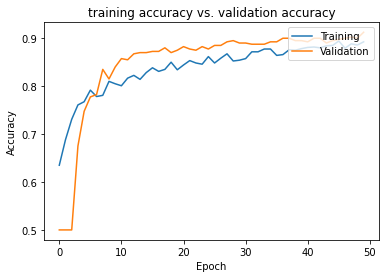

In [ ]:
plt.plot(history.history['binary_accuracy'])
plt.plot(history.history['val_binary_accuracy'])
plt.title('training accuracy vs. validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

In [ ]:
get_val_accuracy(model_4f3, X_val, Y_val)

accuracy: 0.913


In [ ]:
# f
model_4f4 = Sequential([
                    Conv2D(filters=16, kernel_size=(3,3), strides=(1,1), padding='valid', activation = 'relu', input_shape=(64,64,3)), 
                    Flatten(),
                    Dense(units=64, activation='relu', name='dense_1', kernel_initializer='truncated_normal', bias_initializer='zeros'),
                    BatchNormalization(),
                    Dropout(0.3),
                    Dense(1, activation = 'sigmoid')
])

model_4f4.add(tf.keras.layers.BatchNormalization(
    momentum=0.99, # default is 0.99
    epsilon=0.003, #default is 0.001
    axis = -1, #default is -1
    beta_initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.05), # default is beta_initializer='zeros'
    gamma_initializer=tf.keras.initializers.Constant(value=0.9) # default is gamma_initializer='ones'
))

model_4f4.add(Dense(1))


initializer = tf.keras.initializers.TruncatedNormal(mean=0., stddev=1.)
layer = tf.keras.layers.Dense(3, kernel_initializer=initializer)

model_4f4.compile(
    optimizer = tf.keras.optimizers.Adagrad(learning_rate=0.003), # the default values.
    loss = tf.keras.losses.BinaryCrossentropy(from_logits=True),          # use sigmoid activation, if in the final hidden layer, we do not specify an activation function or define a linear one.
    metrics = [tf.keras.metrics.BinaryAccuracy()]            # default is 0.5 (the threshold for predictions to be classed as positive).
)

history = model_4f4.fit(temp_x,temp_y,epochs=50,batch_size=256,verbose=2,validation_split=0.25)


Epoch 1/50
5/5 - 3s - loss: 0.8013 - binary_accuracy: 0.5858 - val_loss: 0.6270 - val_binary_accuracy: 0.6475 - 3s/epoch - 636ms/step
Epoch 2/50
5/5 - 2s - loss: 0.5876 - binary_accuracy: 0.7142 - val_loss: 0.6029 - val_binary_accuracy: 0.6825 - 2s/epoch - 432ms/step
Epoch 3/50
5/5 - 2s - loss: 0.5262 - binary_accuracy: 0.7408 - val_loss: 0.5804 - val_binary_accuracy: 0.7450 - 2s/epoch - 436ms/step
Epoch 4/50
5/5 - 2s - loss: 0.4875 - binary_accuracy: 0.7650 - val_loss: 0.5659 - val_binary_accuracy: 0.7725 - 2s/epoch - 436ms/step
Epoch 5/50
5/5 - 2s - loss: 0.4529 - binary_accuracy: 0.7983 - val_loss: 0.5573 - val_binary_accuracy: 0.7950 - 2s/epoch - 436ms/step
Epoch 6/50
5/5 - 2s - loss: 0.4471 - binary_accuracy: 0.8042 - val_loss: 0.5493 - val_binary_accuracy: 0.8100 - 2s/epoch - 435ms/step
Epoch 7/50
5/5 - 2s - loss: 0.4453 - binary_accuracy: 0.8083 - val_loss: 0.5436 - val_binary_accuracy: 0.8175 - 2s/epoch - 434ms/step
Epoch 8/50
5/5 - 2s - loss: 0.4218 - binary_accuracy: 0.8200 -

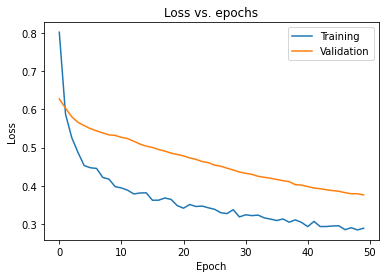

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

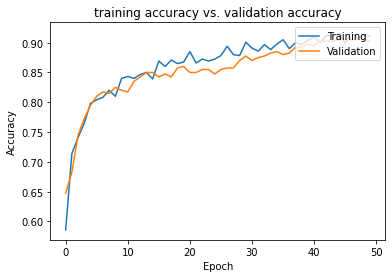

In [ ]:
plt.plot(history.history['binary_accuracy'])
plt.plot(history.history['val_binary_accuracy'])
plt.title('training accuracy vs. validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

In [ ]:
get_val_accuracy(model_4f4, X_val, Y_val)

accuracy: 0.902


In [ ]:
# f
model_4f5 = Sequential([
                    Conv2D(filters=16, kernel_size=(3,3), strides=(1,1), padding='valid', activation = 'relu', input_shape=(64,64,3)), 
                    Flatten(),
                    Dense(units=64, activation='relu', name='dense_1', kernel_initializer='truncated_normal', bias_initializer='zeros'),
                    BatchNormalization(),
                    Dropout(0.4),
                    Dense(1, activation = 'sigmoid')
])

model_4f5.add(tf.keras.layers.BatchNormalization(
    momentum=0.95, # default is 0.99
    epsilon=0.003, #default is 0.001
    axis = -1, #default is -1
    beta_initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.05), # default is beta_initializer='zeros'
    gamma_initializer=tf.keras.initializers.Constant(value=0.9) # default is gamma_initializer='ones'
))

model_4f5.add(Dense(1))


initializer = tf.keras.initializers.TruncatedNormal(mean=0., stddev=1.)
layer = tf.keras.layers.Dense(3, kernel_initializer=initializer)

model_4f5.compile(
    optimizer = tf.keras.optimizers.Adagrad(learning_rate=0.003), # the default values.
    loss = tf.keras.losses.BinaryCrossentropy(from_logits=True),          # use sigmoid activation, if in the final hidden layer, we do not specify an activation function or define a linear one.
    metrics = [tf.keras.metrics.BinaryAccuracy()]            # default is 0.5 (the threshold for predictions to be classed as positive).
)

history = model_4f5.fit(temp_x,temp_y,epochs=50,batch_size=256,verbose=2,validation_split=0.25)


Epoch 1/50
5/5 - 3s - loss: 0.7519 - binary_accuracy: 0.5767 - val_loss: 0.6362 - val_binary_accuracy: 0.7200 - 3s/epoch - 647ms/step
Epoch 2/50
5/5 - 2s - loss: 0.5928 - binary_accuracy: 0.6858 - val_loss: 0.5892 - val_binary_accuracy: 0.7825 - 2s/epoch - 436ms/step
Epoch 3/50
5/5 - 2s - loss: 0.5603 - binary_accuracy: 0.7150 - val_loss: 0.5604 - val_binary_accuracy: 0.7775 - 2s/epoch - 433ms/step
Epoch 4/50
5/5 - 2s - loss: 0.5226 - binary_accuracy: 0.7317 - val_loss: 0.5340 - val_binary_accuracy: 0.7850 - 2s/epoch - 436ms/step
Epoch 5/50
5/5 - 2s - loss: 0.4924 - binary_accuracy: 0.7725 - val_loss: 0.5109 - val_binary_accuracy: 0.8250 - 2s/epoch - 437ms/step
Epoch 6/50
5/5 - 2s - loss: 0.4757 - binary_accuracy: 0.7967 - val_loss: 0.4901 - val_binary_accuracy: 0.8325 - 2s/epoch - 431ms/step
Epoch 7/50
5/5 - 2s - loss: 0.4615 - binary_accuracy: 0.8050 - val_loss: 0.4699 - val_binary_accuracy: 0.8500 - 2s/epoch - 430ms/step
Epoch 8/50
5/5 - 2s - loss: 0.4650 - binary_accuracy: 0.8025 -

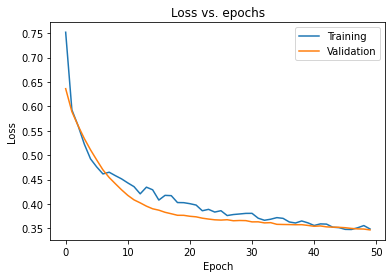

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

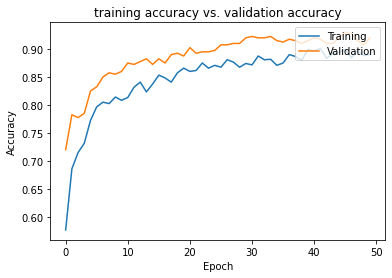

In [ ]:
plt.plot(history.history['binary_accuracy'])
plt.plot(history.history['val_binary_accuracy'])
plt.title('training accuracy vs. validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

In [ ]:
get_val_accuracy(model_4f5, X_val, Y_val)

accuracy: 0.920


## Question 3 - g Batch- normalization, Dropout regularization and L2 regularization

In [ ]:
model_4g1 = Sequential([
                    Conv2D(filters=16, kernel_size=(3,3), strides=(1,1), padding='valid', activation = 'relu', input_shape=(64,64,3)), 
                    Flatten(),
                    Dense(units=64, activation='relu', name='dense_1', kernel_initializer='truncated_normal', bias_initializer='zeros',
                          kernel_regularizer=tf.keras.regularizers.l2(0.001)),
                    BatchNormalization(),
                    Dropout(0.5),
                    Dense(1, activation = 'sigmoid')
])


initializer = tf.keras.initializers.TruncatedNormal(mean=0., stddev=1.)
layer = tf.keras.layers.Dense(3, kernel_initializer=initializer)

model_4g1.compile(
    optimizer = tf.keras.optimizers.Adagrad(learning_rate=0.003), # the default values.
    loss = tf.keras.losses.BinaryCrossentropy(from_logits=True),          # use sigmoid activation, if in the final hidden layer, we do not specify an activation function or define a linear one.
    metrics = [tf.keras.metrics.BinaryAccuracy()]            # default is 0.5 (the threshold for predictions to be classed as positive).
)

history = model_4g1.fit(temp_x,temp_y,epochs=50,batch_size=256,verbose=2,validation_split=0.25)


Epoch 1/50


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


5/5 - 7s - loss: 8.5095 - binary_accuracy: 0.5892 - val_loss: 29.7389 - val_binary_accuracy: 0.5375 - 7s/epoch - 1s/step
Epoch 2/50
5/5 - 4s - loss: 8.3420 - binary_accuracy: 0.7017 - val_loss: 8.8246 - val_binary_accuracy: 0.6800 - 4s/epoch - 823ms/step
Epoch 3/50
5/5 - 4s - loss: 8.2285 - binary_accuracy: 0.7450 - val_loss: 8.3947 - val_binary_accuracy: 0.7375 - 4s/epoch - 842ms/step
Epoch 4/50
5/5 - 4s - loss: 8.1822 - binary_accuracy: 0.7492 - val_loss: 8.1415 - val_binary_accuracy: 0.8050 - 4s/epoch - 798ms/step
Epoch 5/50
5/5 - 4s - loss: 8.1177 - binary_accuracy: 0.7850 - val_loss: 8.1247 - val_binary_accuracy: 0.8025 - 4s/epoch - 777ms/step
Epoch 6/50
5/5 - 2s - loss: 8.1237 - binary_accuracy: 0.7808 - val_loss: 8.1398 - val_binary_accuracy: 0.7925 - 2s/epoch - 463ms/step
Epoch 7/50
5/5 - 2s - loss: 8.0634 - binary_accuracy: 0.8125 - val_loss: 8.0639 - val_binary_accuracy: 0.8125 - 2s/epoch - 447ms/step
Epoch 8/50
5/5 - 2s - loss: 8.0665 - binary_accuracy: 0.8117 - val_loss: 8.

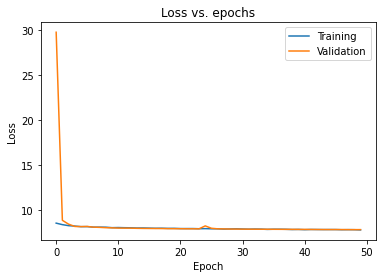

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

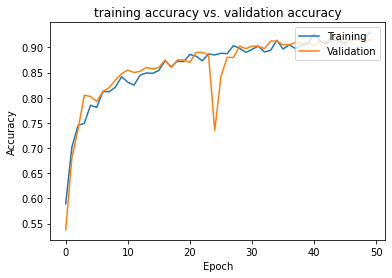

In [ ]:
plt.plot(history.history['binary_accuracy'])
plt.plot(history.history['val_binary_accuracy'])
plt.title('training accuracy vs. validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

In [ ]:
get_val_accuracy(model_4g1, X_val, Y_val)

accuracy: 0.915


In [ ]:
model_4g2 = Sequential([
                    Conv2D(filters=16, kernel_size=(3,3), strides=(1,1), padding='valid', activation = 'relu', input_shape=(64,64,3)), 
                    Flatten(),
                    Dense(units=64, activation='relu', name='dense_1', kernel_initializer='truncated_normal', bias_initializer='zeros',
                          kernel_regularizer=tf.keras.regularizers.l2(0.0025)),
                    BatchNormalization(),
                    Dropout(0.3),
                    Dense(1, activation = 'sigmoid')
])


initializer = tf.keras.initializers.TruncatedNormal(mean=0., stddev=1.)
layer = tf.keras.layers.Dense(3, kernel_initializer=initializer)

model_4g2.compile(
    optimizer = tf.keras.optimizers.Adagrad(learning_rate=0.003), # the default values.
    loss = tf.keras.losses.BinaryCrossentropy(from_logits=True),          # use sigmoid activation, if in the final hidden layer, we do not specify an activation function or define a linear one.
    metrics = [tf.keras.metrics.BinaryAccuracy()]            # default is 0.5 (the threshold for predictions to be classed as positive).
)

history = model_4g2.fit(temp_x,temp_y,epochs=50,batch_size=256,verbose=2,validation_split=0.25)


Epoch 1/50


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


5/5 - 3s - loss: 19.7782 - binary_accuracy: 0.6600 - val_loss: 20.7118 - val_binary_accuracy: 0.7125 - 3s/epoch - 632ms/step
Epoch 2/50
5/5 - 2s - loss: 19.6286 - binary_accuracy: 0.7342 - val_loss: 19.8731 - val_binary_accuracy: 0.7975 - 2s/epoch - 463ms/step
Epoch 3/50
5/5 - 2s - loss: 19.5339 - binary_accuracy: 0.7750 - val_loss: 19.6411 - val_binary_accuracy: 0.8175 - 2s/epoch - 454ms/step
Epoch 4/50
5/5 - 2s - loss: 19.4838 - binary_accuracy: 0.7992 - val_loss: 19.5439 - val_binary_accuracy: 0.8250 - 2s/epoch - 457ms/step
Epoch 5/50
5/5 - 2s - loss: 19.4591 - binary_accuracy: 0.8050 - val_loss: 19.4627 - val_binary_accuracy: 0.8400 - 2s/epoch - 453ms/step
Epoch 6/50
5/5 - 2s - loss: 19.4161 - binary_accuracy: 0.8225 - val_loss: 19.4148 - val_binary_accuracy: 0.8525 - 2s/epoch - 451ms/step
Epoch 7/50
5/5 - 2s - loss: 19.3881 - binary_accuracy: 0.8300 - val_loss: 19.3766 - val_binary_accuracy: 0.8575 - 2s/epoch - 459ms/step
Epoch 8/50
5/5 - 2s - loss: 19.3596 - binary_accuracy: 0.84

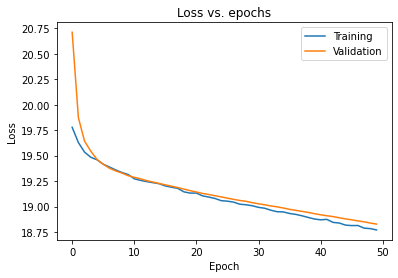

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

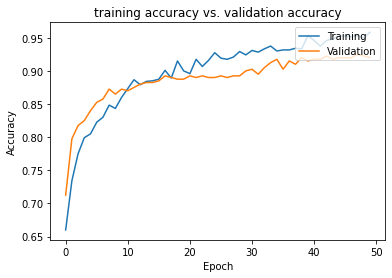

In [ ]:
plt.plot(history.history['binary_accuracy'])
plt.plot(history.history['val_binary_accuracy'])
plt.title('training accuracy vs. validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

In [ ]:
get_val_accuracy(model_4g2, X_val, Y_val)

accuracy: 0.920


In [ ]:
model_4g3 = Sequential([
                    Conv2D(filters=16, kernel_size=(3,3), strides=(1,1), padding='valid', activation = 'relu', input_shape=(64,64,3)), 
                    Flatten(),
                    Dense(units=64, activation='relu', name='dense_1', kernel_initializer='truncated_normal', bias_initializer='zeros',
                          kernel_regularizer=tf.keras.regularizers.l2(0.001)),
                    BatchNormalization(),
                    Dropout(0.5),
                    Dense(1, activation = 'sigmoid')
])

model_4g3.add(tf.keras.layers.BatchNormalization(
    momentum=0.95, # default is 0.99
    epsilon=0.005, #default is 0.001
    axis = -1, #default is -1
    beta_initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.05), # default is beta_initializer='zeros'
    gamma_initializer=tf.keras.initializers.Constant(value=0.9) # default is gamma_initializer='ones'
))

model_4g3.add(Dense(1))


initializer = tf.keras.initializers.TruncatedNormal(mean=0., stddev=1.)
layer = tf.keras.layers.Dense(3, kernel_initializer=initializer)

model_4g3.compile(
    optimizer = tf.keras.optimizers.Adagrad(learning_rate=0.003), # the default values.
    loss = tf.keras.losses.BinaryCrossentropy(from_logits=True),          # use sigmoid activation, if in the final hidden layer, we do not specify an activation function or define a linear one.
    metrics = [tf.keras.metrics.BinaryAccuracy()]            # default is 0.5 (the threshold for predictions to be classed as positive).
)

history = model_4g3.fit(temp_x,temp_y,epochs=50,batch_size=256,verbose=2,validation_split=0.25)


Epoch 1/50
5/5 - 3s - loss: 8.3049 - binary_accuracy: 0.4958 - val_loss: 8.3039 - val_binary_accuracy: 0.5000 - 3s/epoch - 676ms/step
Epoch 2/50
5/5 - 2s - loss: 8.3033 - binary_accuracy: 0.4958 - val_loss: 8.3024 - val_binary_accuracy: 0.5000 - 2s/epoch - 456ms/step
Epoch 3/50
5/5 - 2s - loss: 8.3018 - binary_accuracy: 0.4958 - val_loss: 8.3008 - val_binary_accuracy: 0.5000 - 2s/epoch - 456ms/step
Epoch 4/50
5/5 - 2s - loss: 8.3004 - binary_accuracy: 0.4958 - val_loss: 8.2993 - val_binary_accuracy: 0.5000 - 2s/epoch - 456ms/step
Epoch 5/50
5/5 - 2s - loss: 8.2988 - binary_accuracy: 0.4958 - val_loss: 8.2977 - val_binary_accuracy: 0.5000 - 2s/epoch - 457ms/step
Epoch 6/50
5/5 - 2s - loss: 8.2972 - binary_accuracy: 0.4958 - val_loss: 8.2962 - val_binary_accuracy: 0.5000 - 2s/epoch - 459ms/step
Epoch 7/50
5/5 - 2s - loss: 8.2957 - binary_accuracy: 0.4958 - val_loss: 8.2945 - val_binary_accuracy: 0.5000 - 2s/epoch - 450ms/step
Epoch 8/50
5/5 - 2s - loss: 8.2943 - binary_accuracy: 0.4958 -

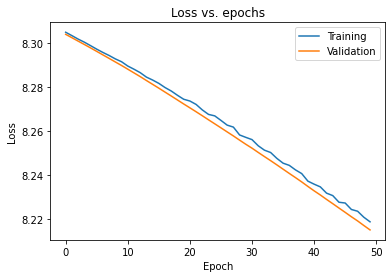

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

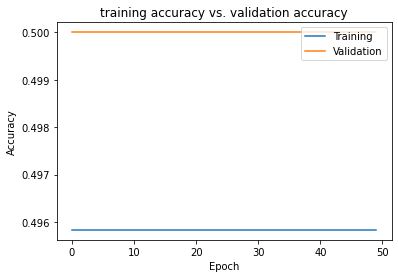

In [ ]:
plt.plot(history.history['binary_accuracy'])
plt.plot(history.history['val_binary_accuracy'])
plt.title('training accuracy vs. validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

In [ ]:
get_val_accuracy(model_4g3, X_val, Y_val)

accuracy: 0.500


In [ ]:
model_4g4 = Sequential([
                    Conv2D(filters=16, kernel_size=(3,3), strides=(1,1), padding='valid', activation = 'relu', input_shape=(64,64,3)), 
                    Flatten(),
                    Dense(units=64, activation='relu', name='dense_1', kernel_initializer='truncated_normal', bias_initializer='zeros',
                          kernel_regularizer=tf.keras.regularizers.l2(0.001)),
                    BatchNormalization(),
                    Dropout(0.5),
                    Dense(1, activation = 'sigmoid')
])

model_4g4.add(tf.keras.layers.BatchNormalization(
    momentum=0.99, # default is 0.99
    epsilon=0.005, #default is 0.001
    axis = -1, #default is -1
    beta_initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.05), # default is beta_initializer='zeros'
    gamma_initializer=tf.keras.initializers.Constant(value=0.9) # default is gamma_initializer='ones'
))

model_4g4.add(Dense(1))


initializer = tf.keras.initializers.TruncatedNormal(mean=0., stddev=1.)
layer = tf.keras.layers.Dense(3, kernel_initializer=initializer)

model_4g4.compile(
    optimizer = tf.keras.optimizers.Adagrad(learning_rate=0.003), # the default values.
    loss = tf.keras.losses.BinaryCrossentropy(from_logits=True),          # use sigmoid activation, if in the final hidden layer, we do not specify an activation function or define a linear one.
    metrics = [tf.keras.metrics.BinaryAccuracy()]            # default is 0.5 (the threshold for predictions to be classed as positive).
)

history = model_4g4.fit(temp_x,temp_y,epochs=50,batch_size=256,verbose=2,validation_split=0.25)


Epoch 1/50
5/5 - 7s - loss: 8.3688 - binary_accuracy: 0.5950 - val_loss: 8.2191 - val_binary_accuracy: 0.7525 - 7s/epoch - 1s/step
Epoch 2/50
5/5 - 5s - loss: 8.1879 - binary_accuracy: 0.6950 - val_loss: 8.1806 - val_binary_accuracy: 0.8025 - 5s/epoch - 954ms/step
Epoch 3/50
5/5 - 5s - loss: 8.1366 - binary_accuracy: 0.7408 - val_loss: 8.1652 - val_binary_accuracy: 0.8300 - 5s/epoch - 909ms/step
Epoch 4/50
5/5 - 4s - loss: 8.1093 - binary_accuracy: 0.7392 - val_loss: 8.1551 - val_binary_accuracy: 0.8350 - 4s/epoch - 713ms/step
Epoch 5/50
5/5 - 3s - loss: 8.0817 - binary_accuracy: 0.7658 - val_loss: 8.1446 - val_binary_accuracy: 0.8450 - 3s/epoch - 560ms/step
Epoch 6/50
5/5 - 2s - loss: 8.0727 - binary_accuracy: 0.7725 - val_loss: 8.1354 - val_binary_accuracy: 0.8500 - 2s/epoch - 449ms/step
Epoch 7/50
5/5 - 2s - loss: 8.0476 - binary_accuracy: 0.8000 - val_loss: 8.1284 - val_binary_accuracy: 0.8525 - 2s/epoch - 449ms/step
Epoch 8/50
5/5 - 2s - loss: 8.0478 - binary_accuracy: 0.8050 - va

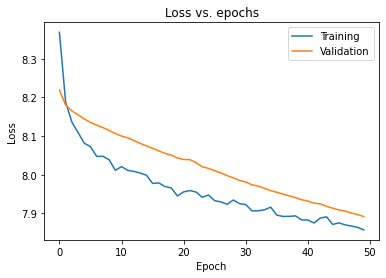

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

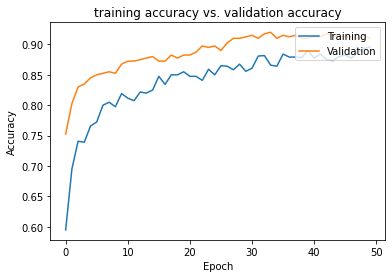

In [ ]:
plt.plot(history.history['binary_accuracy'])
plt.plot(history.history['val_binary_accuracy'])
plt.title('training accuracy vs. validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

In [ ]:
get_val_accuracy(model_4g4, X_val, Y_val)

accuracy: 0.910


In [ ]:
model_4g5 = Sequential([
                    Conv2D(filters=16, kernel_size=(3,3), strides=(1,1), padding='valid', activation = 'relu', input_shape=(64,64,3)), 
                    Flatten(),
                    Dense(units=64, activation='relu', name='dense_1', kernel_initializer='truncated_normal', bias_initializer='zeros',
                          kernel_regularizer=tf.keras.regularizers.l2(0.0015)),
                    BatchNormalization(),
                    Dropout(0.4),
                    Dense(1, activation = 'sigmoid')
])



initializer = tf.keras.initializers.TruncatedNormal(mean=0., stddev=1.)
layer = tf.keras.layers.Dense(3, kernel_initializer=initializer)

model_4g5.compile(
    optimizer = tf.keras.optimizers.Adagrad(learning_rate=0.003), # the default values.
    loss = tf.keras.losses.BinaryCrossentropy(from_logits=True),          # use sigmoid activation, if in the final hidden layer, we do not specify an activation function or define a linear one.
    metrics = [tf.keras.metrics.BinaryAccuracy()]            # default is 0.5 (the threshold for predictions to be classed as positive).
)

history = model_4g5.fit(temp_x,temp_y,epochs=50,batch_size=256,verbose=2,validation_split=0.25)

Epoch 1/50


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


5/5 - 3s - loss: 12.2859 - binary_accuracy: 0.5817 - val_loss: 14.0242 - val_binary_accuracy: 0.6450 - 3s/epoch - 640ms/step
Epoch 2/50
5/5 - 2s - loss: 12.0428 - binary_accuracy: 0.7150 - val_loss: 12.6420 - val_binary_accuracy: 0.7225 - 2s/epoch - 459ms/step
Epoch 3/50
5/5 - 2s - loss: 11.9404 - binary_accuracy: 0.7633 - val_loss: 12.1977 - val_binary_accuracy: 0.7600 - 2s/epoch - 452ms/step
Epoch 4/50
5/5 - 2s - loss: 11.8792 - binary_accuracy: 0.7950 - val_loss: 12.0104 - val_binary_accuracy: 0.7900 - 2s/epoch - 454ms/step
Epoch 5/50
5/5 - 2s - loss: 11.8517 - binary_accuracy: 0.8233 - val_loss: 11.9475 - val_binary_accuracy: 0.8050 - 2s/epoch - 448ms/step
Epoch 6/50
5/5 - 2s - loss: 11.8239 - binary_accuracy: 0.8333 - val_loss: 11.8630 - val_binary_accuracy: 0.8275 - 2s/epoch - 460ms/step
Epoch 7/50
5/5 - 2s - loss: 11.7525 - binary_accuracy: 0.8642 - val_loss: 11.8314 - val_binary_accuracy: 0.8400 - 2s/epoch - 452ms/step
Epoch 8/50
5/5 - 2s - loss: 11.7622 - binary_accuracy: 0.85

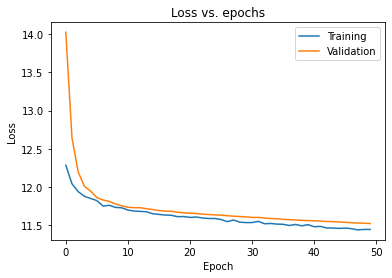

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

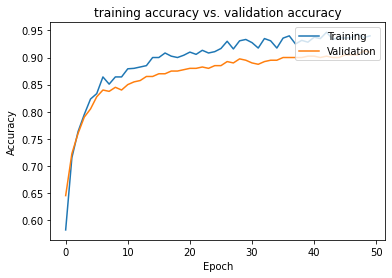

In [ ]:
plt.plot(history.history['binary_accuracy'])
plt.plot(history.history['val_binary_accuracy'])
plt.title('training accuracy vs. validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

In [ ]:
get_val_accuracy(model_4g5, X_val, Y_val)

accuracy: 0.910


## Question 3 - h Early stopping

In [ ]:
model_4h1 = Sequential([
                    Conv2D(filters=16, kernel_size=(3,3), strides=(1,1), padding='valid', activation = 'relu', input_shape=(64,64,3)), 
                    Flatten(),
                    Dense(units=64, activation='relu', name='dense_1', kernel_initializer='truncated_normal', bias_initializer='zeros',
                          kernel_regularizer=tf.keras.regularizers.l2(0.0025)),
                    BatchNormalization(),
                    Dropout(0.3),
                    Dense(1, activation = 'sigmoid')
])


initializer = tf.keras.initializers.TruncatedNormal(mean=0., stddev=1.)
layer = tf.keras.layers.Dense(3, kernel_initializer=initializer)

model_4h1.compile(
    optimizer = tf.keras.optimizers.Adagrad(learning_rate=0.003), # the default values.
    loss = tf.keras.losses.BinaryCrossentropy(from_logits=True),          # use sigmoid activation, if in the final hidden layer, we do not specify an activation function or define a linear one.
    metrics = [tf.keras.metrics.BinaryAccuracy()]            # default is 0.5 (the threshold for predictions to be classed as positive).
)

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0.01, patience=5) 

history = model_4h1.fit(temp_x,temp_y,epochs=50,batch_size=256,verbose=2,validation_split=0.25)

Epoch 1/50


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


5/5 - 3s - loss: 19.8726 - binary_accuracy: 0.5500 - val_loss: 20.5195 - val_binary_accuracy: 0.6400 - 3s/epoch - 671ms/step
Epoch 2/50
5/5 - 2s - loss: 19.6127 - binary_accuracy: 0.7075 - val_loss: 19.7536 - val_binary_accuracy: 0.7675 - 2s/epoch - 452ms/step
Epoch 3/50
5/5 - 2s - loss: 19.5020 - binary_accuracy: 0.7683 - val_loss: 19.5381 - val_binary_accuracy: 0.7975 - 2s/epoch - 443ms/step
Epoch 4/50
5/5 - 2s - loss: 19.4261 - binary_accuracy: 0.7917 - val_loss: 19.4227 - val_binary_accuracy: 0.8275 - 2s/epoch - 445ms/step
Epoch 5/50
5/5 - 2s - loss: 19.3894 - binary_accuracy: 0.8050 - val_loss: 19.3431 - val_binary_accuracy: 0.8400 - 2s/epoch - 445ms/step
Epoch 6/50
5/5 - 2s - loss: 19.3445 - binary_accuracy: 0.8317 - val_loss: 19.3112 - val_binary_accuracy: 0.8500 - 2s/epoch - 446ms/step
Epoch 7/50
5/5 - 2s - loss: 19.3222 - binary_accuracy: 0.8442 - val_loss: 19.2735 - val_binary_accuracy: 0.8625 - 2s/epoch - 440ms/step
Epoch 8/50
5/5 - 2s - loss: 19.2885 - binary_accuracy: 0.86

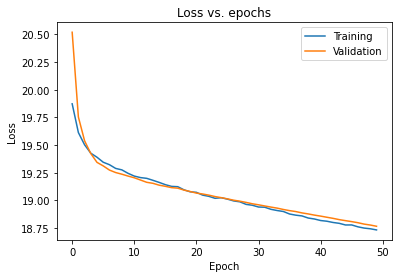

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

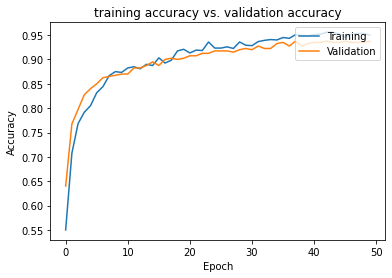

In [ ]:
plt.plot(history.history['binary_accuracy'])
plt.plot(history.history['val_binary_accuracy'])
plt.title('training accuracy vs. validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

In [ ]:
get_val_accuracy(model_4h1, X_val, Y_val)

accuracy: 0.938


In [ ]:
model_4h2 = Sequential([
                    Conv2D(filters=16, kernel_size=(3,3), strides=(1,1), padding='valid', activation = 'relu', input_shape=(64,64,3)), 
                    Flatten(),
                    Dense(units=64, activation='relu', name='dense_1', kernel_initializer='truncated_normal', bias_initializer='zeros',
                          kernel_regularizer=tf.keras.regularizers.l2(0.001)),
                    BatchNormalization(),
                    Dropout(0.3),
                    Dense(1, activation = 'sigmoid')
])


initializer = tf.keras.initializers.TruncatedNormal(mean=0., stddev=1.)
layer = tf.keras.layers.Dense(3, kernel_initializer=initializer)

model_4h2.compile(
    optimizer = tf.keras.optimizers.Adagrad(learning_rate=0.003), # the default values.
    loss = tf.keras.losses.BinaryCrossentropy(from_logits=True),          # use sigmoid activation, if in the final hidden layer, we do not specify an activation function or define a linear one.
    metrics = [tf.keras.metrics.BinaryAccuracy()]            # default is 0.5 (the threshold for predictions to be classed as positive).
)

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0.02, patience=5) 

history = model_4h2.fit(temp_x,temp_y,epochs=50,batch_size=256,verbose=2,validation_split=0.25)

Epoch 1/50


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


5/5 - 3s - loss: 8.5159 - binary_accuracy: 0.5867 - val_loss: 9.9271 - val_binary_accuracy: 0.6225 - 3s/epoch - 618ms/step
Epoch 2/50
5/5 - 2s - loss: 8.2420 - binary_accuracy: 0.7092 - val_loss: 9.0816 - val_binary_accuracy: 0.6900 - 2s/epoch - 453ms/step
Epoch 3/50
5/5 - 2s - loss: 8.1228 - binary_accuracy: 0.7800 - val_loss: 8.4253 - val_binary_accuracy: 0.7700 - 2s/epoch - 465ms/step
Epoch 4/50
5/5 - 2s - loss: 8.0931 - binary_accuracy: 0.7833 - val_loss: 8.2577 - val_binary_accuracy: 0.8100 - 2s/epoch - 455ms/step
Epoch 5/50
5/5 - 2s - loss: 8.0487 - binary_accuracy: 0.8250 - val_loss: 8.1870 - val_binary_accuracy: 0.8100 - 2s/epoch - 450ms/step
Epoch 6/50
5/5 - 2s - loss: 8.0011 - binary_accuracy: 0.8367 - val_loss: 8.1491 - val_binary_accuracy: 0.8150 - 2s/epoch - 449ms/step
Epoch 7/50
5/5 - 3s - loss: 7.9887 - binary_accuracy: 0.8467 - val_loss: 8.0846 - val_binary_accuracy: 0.8275 - 3s/epoch - 551ms/step
Epoch 8/50
5/5 - 2s - loss: 7.9723 - binary_accuracy: 0.8683 - val_loss: 

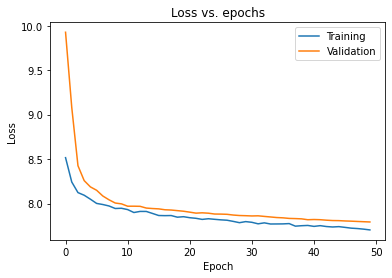

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

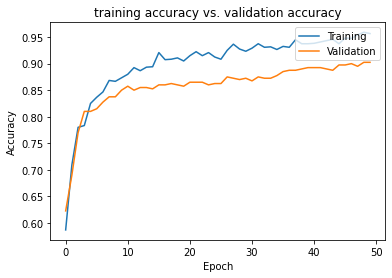

In [ ]:
plt.plot(history.history['binary_accuracy'])
plt.plot(history.history['val_binary_accuracy'])
plt.title('training accuracy vs. validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

In [ ]:
get_val_accuracy(model_4h2, X_val, Y_val)

accuracy: 0.902


In [ ]:
model_4h3 = Sequential([
                    Conv2D(filters=16, kernel_size=(3,3), strides=(1,1), padding='valid', activation = 'relu', input_shape=(64,64,3)), 
                    Flatten(),
                    Dense(units=64, activation='relu', name='dense_1', kernel_initializer='truncated_normal', bias_initializer='zeros',
                          kernel_regularizer=tf.keras.regularizers.l2(0.001)),
                    Dense(1, activation = 'sigmoid')
])

initializer = tf.keras.initializers.TruncatedNormal(mean=0., stddev=1.)
layer = tf.keras.layers.Dense(3, kernel_initializer=initializer)

model_4h3.compile(
    optimizer = tf.keras.optimizers.Adagrad(learning_rate=0.003), # the default values.
    loss = tf.keras.losses.BinaryCrossentropy(from_logits=True),          # use sigmoid activation, if in the final hidden layer, we do not specify an activation function or define a linear one.
    metrics = [tf.keras.metrics.BinaryAccuracy()]            # default is 0.5 (the threshold for predictions to be classed as positive).
)

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0.01, patience=5) 

history = model_4h3.fit(temp_x,temp_y,epochs=50,batch_size=256,verbose=2,validation_split=0.25)

Epoch 1/50


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


5/5 - 6s - loss: 995.3974 - binary_accuracy: 0.5542 - val_loss: 8.7719 - val_binary_accuracy: 0.6550 - 6s/epoch - 1s/step
Epoch 2/50
5/5 - 5s - loss: 8.5437 - binary_accuracy: 0.6633 - val_loss: 8.6631 - val_binary_accuracy: 0.6825 - 5s/epoch - 901ms/step
Epoch 3/50
5/5 - 4s - loss: 8.4315 - binary_accuracy: 0.6850 - val_loss: 8.6234 - val_binary_accuracy: 0.6700 - 4s/epoch - 847ms/step
Epoch 4/50
5/5 - 4s - loss: 8.3846 - binary_accuracy: 0.7033 - val_loss: 8.6004 - val_binary_accuracy: 0.6775 - 4s/epoch - 807ms/step
Epoch 5/50
5/5 - 4s - loss: 8.3562 - binary_accuracy: 0.7117 - val_loss: 8.5855 - val_binary_accuracy: 0.6650 - 4s/epoch - 827ms/step
Epoch 6/50
5/5 - 4s - loss: 8.3250 - binary_accuracy: 0.7175 - val_loss: 8.5568 - val_binary_accuracy: 0.6975 - 4s/epoch - 790ms/step
Epoch 7/50
5/5 - 3s - loss: 8.2977 - binary_accuracy: 0.7292 - val_loss: 8.5275 - val_binary_accuracy: 0.7300 - 3s/epoch - 546ms/step
Epoch 8/50
5/5 - 2s - loss: 8.2746 - binary_accuracy: 0.7325 - val_loss: 8

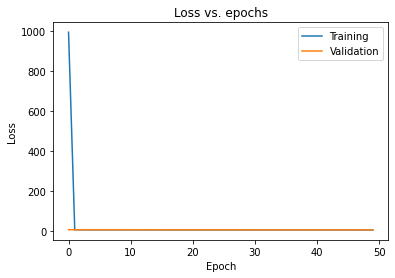

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

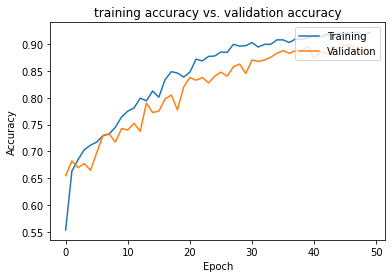

In [ ]:
plt.plot(history.history['binary_accuracy'])
plt.plot(history.history['val_binary_accuracy'])
plt.title('training accuracy vs. validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

In [ ]:
get_val_accuracy(model_4h3, X_val, Y_val)

accuracy: 0.880
